# CS 352: Internet Technology — Programming Assignment 4
## TCP Congestion Control, Routing algorithms, and CRC

- Instructor : Prof. Kim Minsung
- TA: Shrey Patel ( sp2675@scarletmail.rutgers.edu )
- Office Hours : Thursday ( 5:20 PM - 6:40 PM , CORE 305)
- Course Website: [https://sites.google.com/view/cs352fall2025/home](https://sites.google.com/view/cs352fall2025/home)
**Fall 2025**

In this assignment, you will learn core concepts for Transport, Network, and Link layers.


## Table of Contents

1. [Overview](#overview)
2. [File Naming & Submission Instructions](#file-naming--submission-instructions)
3. [Autograder & Graded Functions Overview](#autograder--graded-functions-overview)
4. [Part 1 — TCP Congestion Control (L4)](#part-1--tcp-congestion-control-l4)
5. [Part 2A — Dijkstra / Link-State Routing (L3)](#part-2a--dijkstra--link-state-routing-l3)
6. [Part 2B — Distance Vector Routing (L3)](#part-2b--distance-vector-routing-l3)
7. [Part 3 — Slotted ALOHA & CRC (L2)](#part-3--slotted-aloha--crc-l2)


## Overview

This assignment is divided into three parts (**Total 105 Marks**):

- **Part 1: TCP Congestion Control (25 Marks)**
  - 1.1 Deterministic TCP Simulation (12.5 Marks)
  - 1.2 Probabilistic TCP Simulation (12.5 Marks)

- **Part 2: Routing (50 Marks)**
  - **Part 2A: Dijkstra / Link-State (30 Marks)**
    - 2A.1 Dijkstra Step Table (10 Marks)
    - 2A.2 Forwarding Table (5 Marks)
    - 2A.3 Shortest Path (5 Marks)
    - 2A.4 Packet Simulation with TTL (10 Marks)
  - **Part 2B: Distance Vector (20 Marks)**
    - 2B.1 Initialize distance-vector tables (5 Marks)
    - 2B.2 Distance Vector Round (5 Marks)
    - 2B.3 Link Cost Change (5 Marks)
    - 2B.4 Link Loss (5 Marks)

- **Part 3: Link Layer (30 Marks)**
  - 3.1 Slotted ALOHA Simulation (5 Marks)
  - 3.2 Slotted ALOHA Capacity (5 Marks)
  - 3.3 CRC Remainder (5 Marks)
  - 3.4 CRC Encoding (5 Marks)
  - 3.5 CRC Error Detection (5 Marks)
  - 3.6 Testing check_crc (5 Marks)



---

## File Naming & Submission Instructions

### What to submit

You must submit **one** Jupyter notebook for this assignment:

- **Notebook:** `PA4_<your-netid>.ipynb`
 - Example: if your NetID is `sp2675`, submit `PA4_sp2675.ipynb`.

No additional `.py` files are required; everything should live in this single notebook.

### File naming rules

- Use **lowercase** NetID, no spaces or extra characters.
- Do **not** change the `PA4_` prefix.
- If you resubmit, keep the same filename; the submission system will handle versions.

### Submission process

- Submit `PA4_<your-netid>.ipynb`
- Make sure:
 - The notebook **runs from top to bottom** without errors in a clean environment.
 - All graded functions are defined in the notebook.
 - Any large or long-running experiments are either commented out or clearly separated from the graded functions.

### How the autograder will run your code

For each submission, the autograder will:

1. Load your notebook and execute it in an isolated namespace.
2. Import the expected graded functions (e.g., `simulate_tcp_deterministic, apply_link_loss`, `simulate_slotted_aloha`, `compute_crc_remainder`, etc.).
3. Run tests for each function.
4. Report:
  - which test groups passed/failed,
  - any exceptions raised,
  - and any interface mismatches (wrong name/arguments/return type).

If the notebook fails to load (e.g., JSON corruption, syntax error in a cell), **no tests can be run** and the submission may receive zero for the autograded portion.


---


## Graded functions quick reference

This section lists the main graded functions and their signatures in one place. Detailed behavior and
examples are described later in the notebook near each problem.

- **Part 1 - TCP Congestion Control (25 Marks):**
    - `simulate_tcp_deterministic(num_rounds=20, init_cwnd=1, init_ssthresh=16)` **(12.5 Marks)**
    - `simulate_tcp_probabilistic(num_rounds=40, init_cwnd=1, init_ssthresh=32, prob_3_dup_ack=0.15, prob_timeout=0.05, seed=None)` **(12.5 Marks)**

- **Part 2A - Link-State Routing with Dijkstra (30 Marks):**
    - `step_table_function(graph, source_node, INF=9999999)` **(10 Marks)**
    - `forwarding_table_function(prev, destination)` **(5 Marks)**
    - `Dijkstra_shortest_path(prev, destination)` **(5 Marks)**
    - `simulate_packet(path, ttl)` **(10 Marks)**

- **Part 2B - Distance-Vector Routing (20 Marks):**
    - `initialize_routing_tables(graph, INF=9999999)` **(5 Marks)**
    - `distance_vector_round(graph, routing_tables, INF=9999999)` **(5 Marks)**
    - `apply_link_cost_change(graph, routing_tables, u, v, new_cost, INF=9999999)` **(5 Marks)**
    - `apply_link_loss(graph, routing_tables, u, v, INF=9999999)` **(5 Marks)**

- **Part 3 - Slotted ALOHA and CRC (30 Marks):**
    - `simulate_slotted_aloha(num_users, p, num_slots, seed=None)` **(5 Marks)**
    - `sweep_p_and_plot(num_users=10, num_slots=10000, num_points=1000)` **(5 Marks)**
    - `compute_crc_remainder(data_bits, generator_bits)` **(5 Marks)**
    - `encode_crc(data_bits, generator_bits)` **(5 Marks)**
    - `check_crc(codeword_bits, generator_bits)` **(5 Marks)**
    - Testing `check_crc` **(5 Marks)**



---

In [1]:
!pip install matplotlib
!pip install networkx

import random
import math
import networkx as nx
import matplotlib.pyplot as plt

## Part 1 — TCP Congestion Control (L4)
In this part, you will simulate a simplified version of TCP congestion control and
visualize
how the congestion window (`cwnd`) evolves over time under different conditions.
**Learning goals:**
- Understand how TCP uses **slow start** and **congestion avoidance** to adjust `cwnd`.
- See how **3-Duplicate ACKs** and **timeouts** affect `cwnd` and `ssthresh`.
- Practice designing simulations and plotting time-series network behavior.


### Slow start and additive increase: intuition

Before writing any graded code, it is useful to form a clear mental picture of how TCP changes its
congestion window `cwnd` over time. TCP is always trying to balance two goals. On one hand it would
like to send more data when the network appears to be handling traffic well. On the other hand it
needs to back off when there are signs of congestion such as loss or timeouts.

You can think of TCP as repeatedly asking two questions: can the network handle more data right now,
and did something go wrong in the last round? To explore these questions we will look at two basic
patterns for how `cwnd` grows: an exponential-style growth phase called slow start and a gentler,
linear growth phase called additive increase (congestion avoidance).

In slow start, a simple mental model is that we begin with `cwnd = 1` segment. Each round-trip time
(RTT) that succeeds causes `cwnd` to roughly double. For example, in round 1 we could have
`cwnd = 1`, in round 2 `cwnd = 2`, in round 3 `cwnd = 4`, and in round 4 `cwnd = 8`. This rapid
growth allows TCP to quickly probe how much capacity the network might have.

Once `cwnd` is already large, doubling every RTT would become too aggressive and could easily lead to
congestion. In the congestion-avoidance phase TCP therefore switches to additive increase. Instead of
multiplying, `cwnd` grows by about one segment per RTT. For example, after slow start has taken us to
`cwnd = 10`, the next few rounds might have `cwnd = 11`, then `cwnd = 12`, then `cwnd = 13`, and so
on, increasing in a roughly linear way.

Real TCP also uses a threshold value called `ssthresh` (slow-start threshold) to decide when to stop
using slow start and when to use additive increase. It also has specific rules for what to do when a
loss or timeout happens, for example cutting `cwnd` and reducing `ssthresh`. In the rest of Part 1
you will first experiment with tiny demo simulations of these ideas and then implement your own
simplified TCP simulator that follows a clear set of rules.


### Demo: a tiny cwnd slow-start simulator (not graded)

To make the slow-start idea more concrete, this section provides a small demo function that simulates
`cwnd` growth in a very simplified setting. The goal is not to match every detail of real TCP but to
show the kind of data structure and plot we will use later in the graded problems.

In this demo we begin from a chosen initial congestion window, for example `cwnd = 1`, and run the
simulation for a fixed number of rounds such as ten. During each round we apply a simple rule
inspired by slow start: the next value of `cwnd` is twice the current value, so conceptually we are
using `cwnd_next = 2 * cwnd`. As the rounds progress, the congestion window grows quickly.

As the simulation runs, we record the state in a Python dictionary so that we can inspect and plot it.
A convenient representation uses one list for the round numbers and another list for the
corresponding cwnd values, for example:

```python
{
  "round": [1, 2, 3,..., N],
  "cwnd": [1, 2, 4,..., ],
}
```

The first list simply tracks which round we are in, and the second list stores the congestion window
size for each of those rounds. The demo code defines a function such as
`demo_slow_start(num_rounds, init_cwnd)` that builds this dictionary, returns it to the caller and
then uses Matplotlib to draw a line plot of `cwnd` versus `round`. Looking at both the printed
dictionary and the plot should help you see the exponential-style growth produced by slow start.

This demo is not graded. Its main purpose is to illustrate how we can represent a time series of
`cwnd` values in Python and how we can visualize that time series with a simple plot. Later graded
functions in Part 1 will return dictionaries with the same general shape but will use more realistic
rules for how `cwnd` changes over time.

# Note : For all simulations, assume a constant Round Trip Time (RTT), so 1 simulation round equates to 1 RTT.

Demo results dictionary: {'round': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'cwnd': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]}


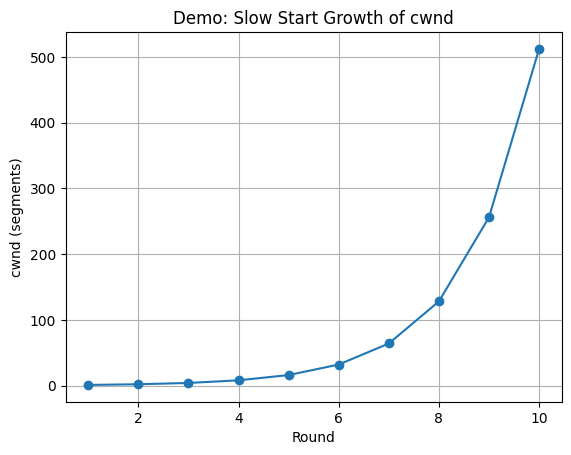

In [2]:
#run this cell to see the output graph, observe the code here , you will be coding similar case in next cells
import matplotlib.pyplot as plt

def demo_slow_start(num_rounds=10, init_cwnd=1):

  rounds = []
  cwnds = []

  cwnd = init_cwnd
  for r in range(1, num_rounds + 1):
    rounds.append(r)
    cwnds.append(cwnd)
    # Slow start: double cwnd each round (no loss, no threshold)
    cwnd *= 2

  results = {"round": rounds, "cwnd": cwnds}
  return results

# Run the demo and visualize the result
demo_results = demo_slow_start(num_rounds=10, init_cwnd=1)
print("Demo results dictionary:", demo_results)

plt.figure()
plt.plot(demo_results["round"], demo_results["cwnd"], marker="o")
plt.xlabel("Round")
plt.ylabel("cwnd (segments)")
plt.title("Demo: Slow Start Growth of cwnd")
plt.grid(True)
plt.show()

#see how i have stored the round and cwnd in a dictionary. your code will have similar output dictionaries.

### Demo : additive increase (congestion avoidance) (not graded)

In the previous demo you saw how slow start causes the congestion window to grow very quickly by
doubling every round. In real TCP this behavior only makes sense when `cwnd` is still small. Once
`cwnd` is large, TCP switches to a more cautious mode called congestion avoidance, where the window
increases much more slowly.

This second demo focuses on that additive-increase behavior. We start from a larger congestion
window, for example `cwnd = 10` segments, and run the simulation for a small number of rounds such as
10. In each round we apply a simple rule that represents congestion avoidance: the new congestion
window is the old one plus one segment, so conceptually `cwnd_next = cwnd + 1`. The resulting
sequence might begin `10, 11, 12, 13,...` and forms a roughly straight line when plotted.

As before, we store the results of the simulation in a small dictionary with two lists: one list for
the round numbers and one list for the corresponding cwnd values. The plotting code then reads these
lists and draws a line showing how `cwnd` changes over time. Comparing this plot to the slow-start
plot should make it clear how exponential growth and linear growth differ.

This demo is not graded. Its purpose is to give you an intuitive feel for congestion avoidance and to
reinforce the pattern of representing time-series data (here, `cwnd` over rounds) as a dictionary of
simple Python lists.


Additive-increase demo dictionary: {'round': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'cwnd': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}


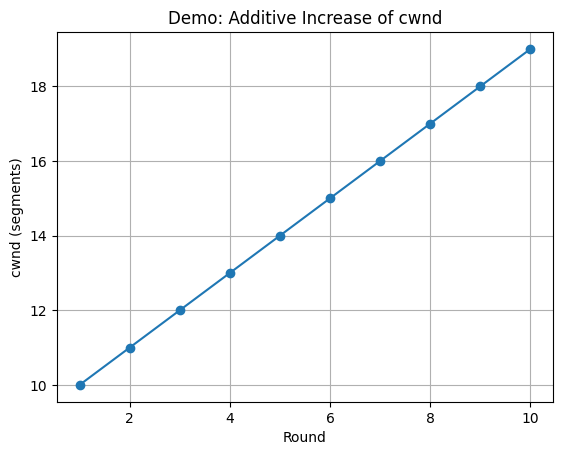

In [3]:
#run this code , observe how the cwnd changes differently in additive increase than in slow start.
import matplotlib.pyplot as plt

def demo_additive_increase(num_rounds=10, init_cwnd=10):

  rounds = []
  cwnds = []

  cwnd = init_cwnd
  for r in range(1, num_rounds + 1):
    rounds.append(r)
    cwnds.append(cwnd)
    # Additive increase: increase cwnd by 1 each round
    cwnd += 1

  results = {"round": rounds, "cwnd": cwnds}
  return results

# Run the additive-increase demo and visualize the result
add_results = demo_additive_increase(num_rounds=10, init_cwnd=10)
print("Additive-increase demo dictionary:", add_results)

plt.figure()
plt.plot(add_results["round"], add_results["cwnd"], marker="o")
plt.xlabel("Round")
plt.ylabel("cwnd (segments)")
plt.title("Demo: Additive Increase of cwnd")
plt.grid(True)
plt.show()


### Demo: putting it together - ssthresh, timeout, and 3 duplicate ACKs (not graded)

The previous demos isolated slow start and additive increase. In this third demo you see how TCP
combines these ideas and reacts to two important congestion signals: timeouts and three duplicate
ACKs. The goal is to visualize how `cwnd` and the slow-start threshold `ssthresh` evolve when these
events occur.

We begin with `cwnd = 1` and a chosen `ssthresh` value such as 8. At first the behavior looks like
pure slow start: on each successful round the congestion window doubles until it reaches or exceeds
`ssthresh`. Once that happens the growth pattern changes into additive increase and `cwnd` grows by
roughly one segment per round.

At a designated round we simulate the arrival of three duplicate ACKs. In this simplified model that
event is interpreted as a loss event (3-Duplicate ACKs). TCP responds by cutting the congestion window roughly
in half and updating `ssthresh` to this new value, but it does not reset `cwnd` all the way back to
Later in the demo we simulate a timeout, which represents more serious congestion. In response to a
timeout TCP again halves `ssthresh` but now it also resets `cwnd` to 1, causing the connection to go
back into slow start.

The demo records the values of `round`, `cwnd`, `ssthresh`, and a simple label indicating whether a
special event occurred in that round. It then prints this data structure and plots both `cwnd` and
`ssthresh` as functions of the round number, marking the rounds where the duplicate-ACK and timeout
events occur. By examining this plot you can see how TCP alternates between probing aggressively,
backing off, and then cautiously increasing its sending rate again.

This combined demo is not graded. It is meant to provide an overall picture of how slow start,
congestion avoidance, `ssthresh`, and congestion signals interact before you implement your own
simplified deterministic and probabilistic simulators in the graded parts of Part 1.


**Note on Visualization:** To visually represent the drop as an instantaneous event, this demo applies the drop to the *previous* round's value retroactively. For example, if a timeout occurs at Round 11, the graph will show the drop occurring vertically at Round 10, and Round 11 will start the new Slow Start phase. This creates a 'straight drop' effect on the plot, rather than a slanted line between rounds.


Event demo dictionary: {'round': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'cwnd': [1, 2, 4, 8, 9, 10, 6, 7, 8, 9, 2, 4, 5, 6, 7, 8], 'ssthresh': [8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4], 'event': ['none', 'none', 'none', 'none', 'none', 'dup_ack', 'none', 'none', 'none', 'timeout', 'none', 'none', 'none', 'none', 'none', 'none'], 'plot_data': [{'r': 1, 'c': 1, 'ss': 8, 'type': 'start'}, {'r': 2, 'c': 2, 'ss': 8, 'type': 'start'}, {'r': 3, 'c': 4, 'ss': 8, 'type': 'start'}, {'r': 4, 'c': 8, 'ss': 8, 'type': 'start'}, {'r': 5, 'c': 9, 'ss': 8, 'type': 'start'}, {'r': 6, 'c': 10, 'ss': 8, 'type': 'start'}, {'r': 6, 'c': 5, 'ss': 5, 'type': 'drop'}, {'r': 7, 'c': 6, 'ss': 5, 'type': 'start'}, {'r': 8, 'c': 7, 'ss': 5, 'type': 'start'}, {'r': 9, 'c': 8, 'ss': 5, 'type': 'start'}, {'r': 10, 'c': 9, 'ss': 5, 'type': 'start'}, {'r': 10, 'c': 1, 'ss': 4, 'type': 'drop'}, {'r': 11, 'c': 2, 'ss': 4, 'type': 'start'}, {'r': 12, 'c': 4, 'ss': 4, 'type': 'start'}, {'r': 13, '

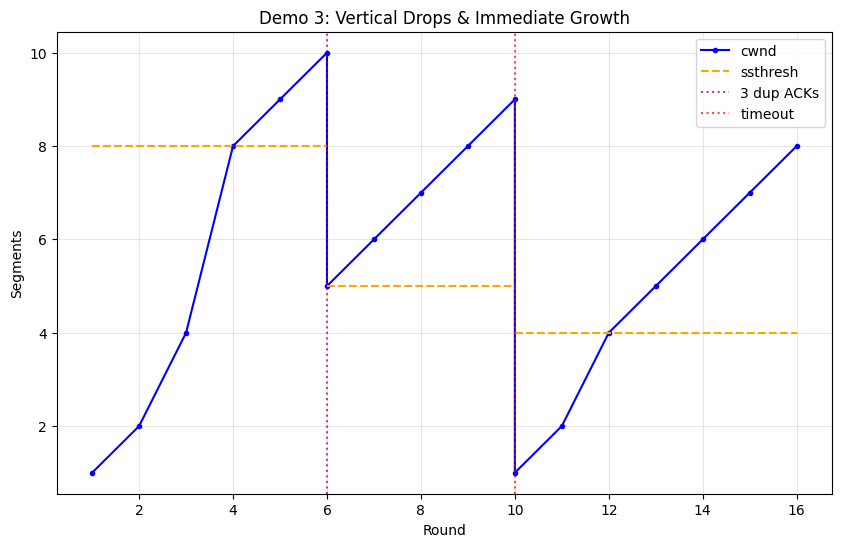

In [4]:
import matplotlib.pyplot as plt

def demo_tcp_events(num_rounds=16, init_cwnd=1, init_ssthresh=8):

  cwnd = init_cwnd
  ssthresh = init_ssthresh

  rounds = []
  cwnds = []
  ssthreshes = []
  events = [] # 'none', 'dup_ack', or 'timeout'

  # For detailed plotting
  plot_data = []

  dup_ack_round = 6   # Peak round before drop
  timeout_round = 10  # Peak round before drop

  for r in range(1, num_rounds + 1):
    event = 'none'

    if r == dup_ack_round:
      event = 'dup_ack'
    elif r == timeout_round:
      event = 'timeout'

    # 1. Record State (Start of Round / Peak)
    rounds.append(r)
    cwnds.append(cwnd)
    ssthreshes.append(ssthresh)
    events.append(event)

    plot_data.append({'r': r, 'c': cwnd, 'ss': ssthresh, 'type': 'start'})

    # 2. Handle Events or Apply Growth
    if event == 'timeout':
      # Drop
      ssthresh = max(cwnd // 2, 1)
      cwnd = 1
      plot_data.append({'r': r, 'c': cwnd, 'ss': ssthresh, 'type': 'drop'})

      # Immediate Growth on the dropped value
      if cwnd < ssthresh:
          if cwnd * 2 > ssthresh:
               cwnd = ssthresh
          else:
               cwnd *= 2
      else:
          cwnd += 1

    elif event == 'dup_ack':
      # Drop
      ssthresh = max(cwnd // 2, 1)
      cwnd = ssthresh
      plot_data.append({'r': r, 'c': cwnd, 'ss': ssthresh, 'type': 'drop'})

      # Immediate Growth on the dropped value
      if cwnd < ssthresh:
          if cwnd * 2 > ssthresh:
               cwnd = ssthresh
          else:
               cwnd *= 2
      else:
          cwnd += 1

    else:
      # No event, just grow for next round
      if cwnd < ssthresh:
          if cwnd * 2 > ssthresh:
               cwnd = ssthresh
          else:
               cwnd *= 2
      else:
          cwnd += 1

    # No 'end' point needed, the next 'start' will show the growth

  return {
    'round': rounds,
    'cwnd': cwnds,
    'ssthresh': ssthreshes,
    'event': events,
    'plot_data': plot_data
  }

# Run the combined demo
event_results = demo_tcp_events()
print("Event demo dictionary:", event_results)

# Visualization Logic
# We use the detailed 'plot_data' if available, otherwise fallback (though we just added it)
plot_data = event_results.get('plot_data', [])

plot_rounds = []
plot_cwnd = []
# Separate arrays for ssthresh to allow independent breaks
plot_ss_x = []
plot_ss_y = []

# If we have detailed plot data, use it to draw the vertical drops and skips
if plot_data:
    for i, pt in enumerate(plot_data):
        r = pt['r']
        c = pt['c']
        ss = pt['ss']
        pt_type = pt['type']

        # Plot cwnd (continuous with vertical drops)
        plot_rounds.append(r)
        plot_cwnd.append(c)

        # Plot ssthresh (disconnected at drops)
        if pt_type == 'drop':
            # Break the line before plotting the new drop value
            plot_ss_x.append(r)
            plot_ss_y.append(None)

        plot_ss_x.append(r)
        plot_ss_y.append(ss)

else:
    # Fallback
    raw_rounds = event_results['round']
    raw_cwnds = event_results['cwnd']
    raw_ssthreshes = event_results['ssthresh']
    plot_rounds = raw_rounds
    plot_cwnd = raw_cwnds
    plot_ss_x = raw_rounds
    plot_ss_y = raw_ssthreshes

plt.figure(figsize=(10, 6))
plt.plot(plot_rounds, plot_cwnd, marker='.', linestyle='-', label='cwnd', color='blue')
plt.plot(plot_ss_x, plot_ss_y, linestyle='--', label='ssthresh', color='orange')

# Mark events
raw_events = event_results['event']
raw_rounds_list = event_results['round']
added_timeout = False
added_dupack = False

for r, ev in zip(raw_rounds_list, raw_events):
  if ev == 'dup_ack':
    lbl = '3 dup ACKs' if not added_dupack else None
    plt.axvline(r, color='purple', linestyle=':', label=lbl, alpha=0.7)
    added_dupack = True
  elif ev == 'timeout':
    lbl = 'timeout' if not added_timeout else None
    plt.axvline(r, color='red', linestyle=':', label=lbl, alpha=0.7)
    added_timeout = True

plt.xlabel('Round')
plt.ylabel('Segments')
plt.title('Demo 3: Vertical Drops & Immediate Growth')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


**Growth Logic (Important):**
*   If `cwnd < ssthresh`:
    *   If `cwnd * 2 > ssthresh`: **Transition Round**. Set `cwnd = ssthresh`.
    *   Else: **Slow Start**. Double `cwnd` (`cwnd = cwnd * 2`).
*   If `cwnd >= ssthresh`: **Congestion Avoidance**. Additive Increase (`cwnd = cwnd + 1`).


### 1.1 - Deterministic TCP Simulation (12.5 Marks)

**Scenario:**

* From rounds 1 to 5, use the Growth Logic starting with `cwnd=1`. (Standard Slow Start).
* From rounds 6 to 9, continue using Growth Logic (likely Additive Increase).
* At round 10, a **timeout event** occurs:
    *   **Round 10**: Calculate Peak using Growth Logic. Record event `"timeout"`.
    *   **Impact**: The `cwnd` is reset to 1, and `ssthresh` is updated to **10**.
    *   **Immediate Growth**: Apply Growth Logic to the *new* `cwnd=1` in the same round.
* From rounds 11 to 14, use Growth Logic from the reset values.
* At round 15, a **three-duplicated-ACK event** occurs:
    *   **Round 15**: Calculate Peak using Growth Logic. Record event `"dup_ack"`.
    *   **Impact**: The `cwnd` is updated to **5**, and `ssthresh` is updated to **5**.
    *   **Immediate Growth**: Apply Growth Logic to the *new* `cwnd=5` in the same round.
* From rounds 16 to 20, resume Growth Logic from the new state.

**Constraints:**

* Total Rounds: 20
* Initial `cwnd`: 1
* Initial `ssthresh`: 16
* Events: Round 10 (Timeout), Round 15 (3-Dup ACK)


**Note on Division:** When computing `cwnd // 2`, Python's floor division operator (`//`) rounds down to the nearest integer. For example, if `cwnd = 17`, then `cwnd // 2 = 8` (not 8.5).


**Simulation Loop Order (Critical):**

To ensure your results match the expected output and graphs, follow this exact order inside your loop `for r in range(1, num_rounds + 1):`:

1.  **Record State:** At the very *start* of the round (before any changes), append the current `round`, `cwnd`, `ssthresh`, and `event` to your results.
2.  **Handle Events (Drop):**
    *   Check if an event (Timeout or 3-Dup ACK) occurs in this round.
    *   If yes, update `ssthresh` and `cwnd` based on the *current* values (from Step 1).
        *   Timeout: `ssthresh = max(cwnd // 2, 1)`, `cwnd = 1`
        *   3-Dup ACK: `ssthresh = max(cwnd // 2, 1)`, `cwnd = ssthresh`
3.  **Apply Growth (Always):**
    *   **Immediately** apply the Growth Logic (Slow Start or Congestion Avoidance) to the `cwnd` from Step 2.
    *   This happens *every* round, even if a drop just occurred. This ensures `cwnd` starts recovering in the same round.
    *   The value you compute here will be the `cwnd` recorded at the *start* of the *next* round.


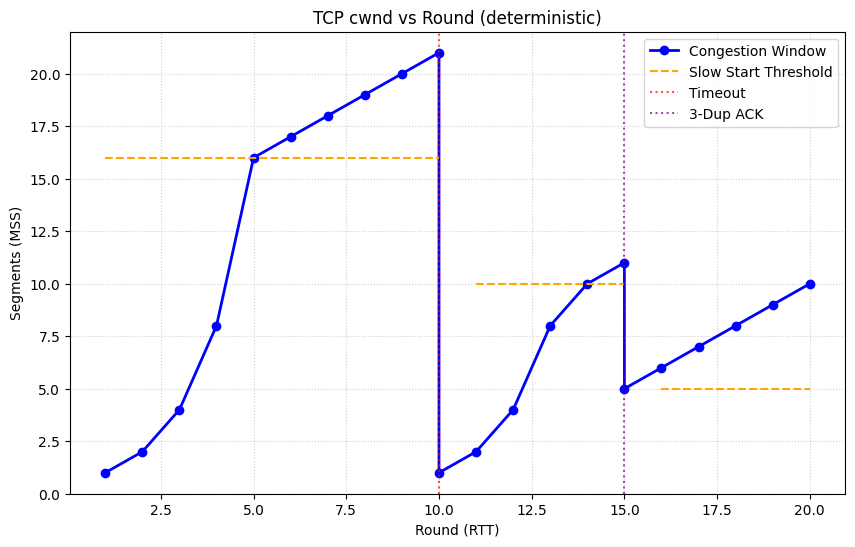

In [5]:
import matplotlib.pyplot as plt
def simulate_tcp_deterministic(num_rounds=20, init_cwnd=1, init_ssthresh=16):
    """
    Simulate the deterministic TCP congestion-control scenario from Problem 3.1.
    This function models the evolution of congestion window (cwnd) and slow start threshold (ssthresh).

    Parameters:
    num_rounds (int): Number of rounds (RTTs) to simulate.
    init_cwnd (int): Initial size of the congestion window.
    init_ssthresh (int): Initial slow start threshold.

    Returns:
    dict: Results containing lists for 'round', 'cwnd', 'ssthresh', and 'event'.
    """
    #initiliaze variables and create record lists
    cwnd = init_cwnd
    ssthresh = init_ssthresh
    round = []
    cwnds = []
    ssthreshes = []
    events = []

    for r in range(1, num_rounds + 1):
        round.append(r)
        cwnds.append(cwnd)
        ssthreshes.append(ssthresh)
        event = 'none'

        if r == 10:
            event = 'timeout'
            ssthresh = 10
            cwnd = 1
        elif r == 15:
            event = 'dup_ack'
            ssthresh = 5
            cwnd = 5

        if cwnd < ssthresh:
            if cwnd*2 > ssthresh:
                cwnd = ssthresh
            else:
                cwnd *= 2
        else:
            cwnd +=1

        events.append(event)
    return{
        'round': round,
        'cwnd': cwnds,
        'ssthresh' : ssthreshes,
        'event' : events,
    }
def plot_tcp_deterministic(results, title="TCP cwnd vs Round (deterministic)"):
  """
  Visualize the results of the deterministic TCP simulation.
  """
  rounds = results["round"]
  cwnd = results["cwnd"]
  ssthresh = results.get("ssthresh")
  events = results.get("event", [])

  # --- Pre-processing (Provided) ---
  plot_rounds = []
  plot_cwnd = []
  ssthresh_segments = []

  curr_ss_x, curr_ss_y = [], []
  last_ss = -1

  for i in range(len(rounds)):
    r, c = rounds[i], cwnd[i]
    s = ssthresh[i] if ssthresh else None

    plot_rounds.append(r)
    plot_cwnd.append(c)

    # Segment ssthresh
    if ssthresh:
        if i == 0:
            curr_ss_x, curr_ss_y = [r], [s]
            last_ss = s
        else:
            if s != last_ss:
                ssthresh_segments.append((curr_ss_x, curr_ss_y))
                curr_ss_x, curr_ss_y = [r], [s]
                last_ss = s
            else:
                curr_ss_x.append(r)
                curr_ss_y.append(s)

    # Vertical drops
    if events and i < len(events):
        if events[i] == "timeout":
            plot_rounds.append(r)
            plot_cwnd.append(1)
        elif events[i] == "dup_ack":
            drop_val = max(c // 2, 1)
            plot_rounds.append(r)
            plot_cwnd.append(drop_val)

  if curr_ss_x: ssthresh_segments.append((curr_ss_x, curr_ss_y))

  # --- Student Code Start ---
  plt.figure(figsize=(10, 6))
  plt.plot(plot_rounds, plot_cwnd, marker="o", color="blue", label="Congestion Window", linewidth=2)

  if ssthresh:
      first = True
      for seg_x, seg_y in ssthresh_segments:
          label = "Slow Start Threshold" if first else None
          plt.plot(seg_x, seg_y, linestyle="--", color="orange", label=label)
          first = False

  # Event Lines
  added_timeout = False
  added_dupack = False
  for i, evt in enumerate(events):
      if evt == "timeout":
          lbl = "Timeout" if not added_timeout else None
          plt.axvline(x=rounds[i], color='red', linestyle=':', label=lbl, alpha=0.7)
          added_timeout = True
      elif evt == "dup_ack":
          lbl = "3-Dup ACK" if not added_dupack else None
          plt.axvline(x=rounds[i], color='purple', linestyle=':', label=lbl, alpha=0.7)
          added_dupack = True

  plt.xlabel("Round (RTT)")
  plt.ylabel("Segments (MSS)")
  plt.title(title)
  plt.grid(True, linestyle=":", alpha=0.6)
  plt.legend()
  plt.show()
  # --- Student Code End ---

#run the code?
simulation_results = simulate_tcp_deterministic()
plot_tcp_deterministic(simulation_results)

### Expected Output:
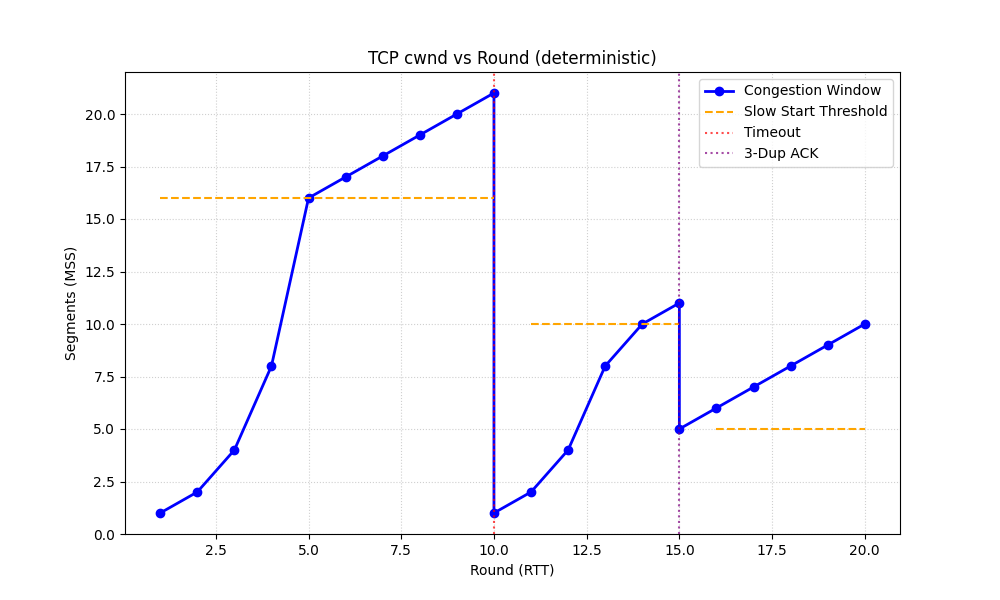


### 1.2 - Probabilistic TCP Simulation (12.5 Marks)

Next, you will extend your simulator to a **probabilistic** setting where loss events (Timeout or 3-Duplicate ACKs) happen at
random. The structure of the code and the return value stays the same.

You will write:
- `simulate_tcp_probabilistic(num_rounds=40, init_cwnd=1, init_ssthresh=32, prob_3_dup_ack=0.15, prob_timeout=0.05, seed=None)`
- `plot_tcp_probabilistic(results, title="TCP cwnd vs Round (probabilistic)")`

The simulator again returns a dictionary with keys `"round"`, `"cwnd"`, `"ssthresh"`, and `"event"`,
each mapping to a list of values of the same length.

A common way to use probabilities in code is:

```python
if rng.random() < p:  # with probability p, handle the event
 ...        # otherwise, fall through and do nothing special
```

Here you will use the global `random` module (e.g., `random.random()`).

#### Per-round behavior

Start with integer `cwnd = init_cwnd` and `ssthresh = init_ssthresh`.
For each round `r = 1.. num_rounds`:

1. **Record State**: Append the current `round`, `cwnd`, and `ssthresh` to your result lists.

2. **Determine Event**: Use probabilities to decide if a loss event occurs:
  - With probability `prob_timeout`, a **Timeout** loss occurs.
  - With probability `prob_3_dup_ack`, a **3-Duplicate ACK** loss occurs.
  - Otherwise, no loss occurs.
  
  (Note: For this simulation, assume these probabilities are additive and the events are mutually exclusive. i.e., a loss of *any* kind occurs with probability `prob_3_dup_ack + prob_timeout`.)

3. **Apply Drop (if any)**:
  - **IF a Timeout occurs**:
    * Record event `"timeout"`
    * Use CURRENT cwnd to calculate drop: `ssthresh = max(cwnd // 2, 1)`
    * Update cwnd: `cwnd = 1`
  
  - **IF a 3-Dup ACK occurs**:
    * Record event `"dup_ack"`
    * Use CURRENT cwnd to calculate drop: `ssthresh = max(cwnd // 2, 1)`
    * Update cwnd: `cwnd = ssthresh`
  
  - **IF no event occurs**:
    * Record event `"none"`

4. **Apply Growth (ALWAYS)**:
   * Apply **Growth Logic** to calculate next cwnd:
      - If `cwnd < ssthresh` and `cwnd * 2 > ssthresh`: `cwnd = ssthresh` (Transition)
      - Else if `cwnd < ssthresh`: `cwnd = cwnd * 2` (Slow Start)
      - Else: `cwnd = cwnd + 1` (Congestion Avoidance)

**IMPORTANT**: Drop calculations (`ssthresh = max(cwnd // 2, 1)`) use the cwnd value at the START of the round, NOT after applying growth.

**Note on Division:** When computing `cwnd // 2`, Python's floor division operator (`//`) rounds down to the nearest integer. For example, if `cwnd = 17`, then `cwnd // 2 = 8` (not 8.5).



**Simulation Loop Order (Critical):**

To ensure consistency with Part 1.1, follow this exact order inside your loop:

1.  **Record State:** At the very *start* of the round, append the current `round`, `cwnd`, `ssthresh`, and `event` to your results.
2.  **Determine & Handle Events:**
    *   Use `rng.random()` to determine if an event occurs.
    *   If an event occurs (Timeout or 3-Dup ACK), update `ssthresh` and `cwnd` based on the *current* values (from Step 1).
3.  **Apply Growth (Always):**
    *   **Immediately** apply the Growth Logic to the `cwnd` from Step 2.
    *   This happens *every* round, ensuring `cwnd` starts recovering in the same round as a drop.


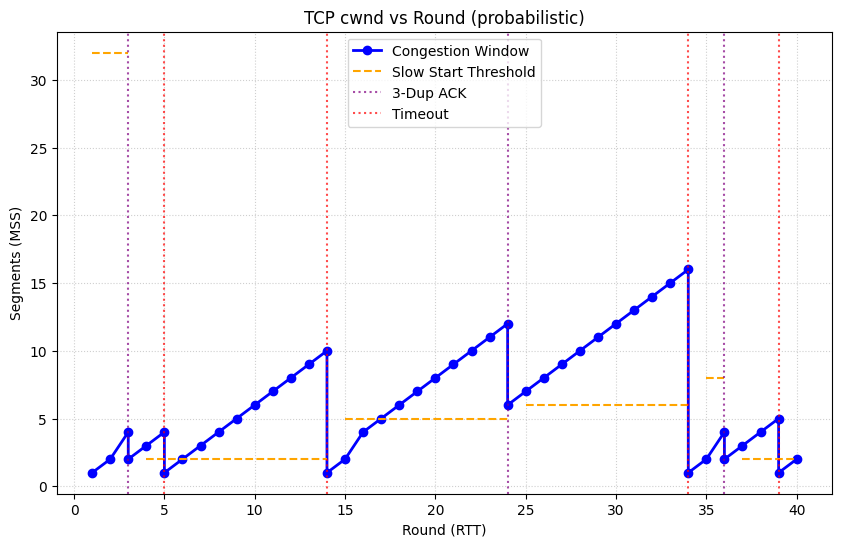

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

def simulate_tcp_probabilistic(num_rounds=40, init_cwnd=1, init_ssthresh=32,
                               prob_3_dup_ack=0.15, prob_timeout=0.05, seed=None):
    """
    Simulate the probabilistic TCP congestion-control scenario from Problem 3.2.
    This function introduces random loss events that trigger either timeouts or duplicate ACKs.

    Parameters:
    num_rounds (int): Number of rounds (RTTs) to simulate.
    init_cwnd (int): Initial size of the congestion window.
    init_ssthresh (int): Initial slow start threshold.
    prob_3_dup_ack (float): Probability of a 3-Duplicate ACK event in a given round.
    prob_timeout (float): Probability of a Timeout event in a given round.
    seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
    dict: Results containing lists for 'round', 'cwnd', 'ssthresh', and 'event'.
    """
    if seed is not None:
      random.random(seed)

    #initiliaze variables and create record lists
    cwnd = init_cwnd
    ssthresh = init_ssthresh
    round = []
    cwnds = []
    ssthreshes = []
    events = []

    for r in range(1, num_rounds + 1):
        round.append(r)
        cwnds.append(cwnd)
        ssthreshes.append(ssthresh)
        event = 'none'

        #event simulation
        p = 0.15 + 0.05
        randVal = random.random()
        if randVal <= p: #probability of dupe (0.15) + timeout (0.05)
            if randVal < prob_3_dup_ack:
                event = "dup_ack"
                #logic for what happens during dupe
                ssthresh = max(cwnd//2, 1)
                cwnd = ssthresh
            else:
                event = 'timeout'
                #logic for timeout
                ssthresh = max(cwnd//2, 1)
                cwnd = 1

        #normal growth
        if cwnd < ssthresh:
            if cwnd*2 > ssthresh:
                cwnd = ssthresh
            else:
                cwnd *= 2
        else:
            cwnd +=1

        events.append(event)
    return{
        'round': round,
        'cwnd': cwnds,
        'ssthresh' : ssthreshes,
        'event' : events,
    }

def plot_tcp_probabilistic(results, title="TCP cwnd vs Round (probabilistic)"):
  """
  Helper function to plot probabilistic TCP simulation results.
  """
  rounds = results["round"]
  cwnd = results["cwnd"]
  ssthresh = results.get("ssthresh")
  events = results.get("event", [])

  # --- Pre-processing (Provided) ---
  plot_rounds = []
  plot_cwnd = []
  ssthresh_segments = []

  curr_ss_x, curr_ss_y = [], []
  last_ss = -1

  for i in range(len(rounds)):
    r, c = rounds[i], cwnd[i]
    s = ssthresh[i] if ssthresh else None

    plot_rounds.append(r)
    plot_cwnd.append(c)

    if ssthresh:
        if i == 0:
            curr_ss_x, curr_ss_y = [r], [s]
            last_ss = s
        else:
            if s != last_ss:
                ssthresh_segments.append((curr_ss_x, curr_ss_y))
                curr_ss_x, curr_ss_y = [r], [s]
                last_ss = s
            else:
                curr_ss_x.append(r)
                curr_ss_y.append(s)

    if events and i < len(events):
        if events[i] == "timeout":
            plot_rounds.append(r)
            plot_cwnd.append(1)
        elif events[i] == "dup_ack":
            drop_val = max(c // 2, 1)
            plot_rounds.append(r)
            plot_cwnd.append(drop_val)

  if curr_ss_x: ssthresh_segments.append((curr_ss_x, curr_ss_y))

  # --- Student Code Start ---
  plt.figure(figsize=(10, 6))
  plt.plot(plot_rounds, plot_cwnd, marker="o", color="blue", label="Congestion Window", linewidth=2)

  if ssthresh:
      first = True
      for seg_x, seg_y in ssthresh_segments:
          label = "Slow Start Threshold" if first else None
          plt.plot(seg_x, seg_y, linestyle="--", color="orange", label=label)
          first = False

  # Event Lines
  added_timeout = False
  added_dupack = False
  for i, evt in enumerate(events):
      if evt == "timeout":
          lbl = "Timeout" if not added_timeout else None
          plt.axvline(x=rounds[i], color='red', linestyle=':', label=lbl, alpha=0.7)
          added_timeout = True
      elif evt == "dup_ack":
          lbl = "3-Dup ACK" if not added_dupack else None
          plt.axvline(x=rounds[i], color='purple', linestyle=':', label=lbl, alpha=0.7)
          added_dupack = True

  plt.xlabel("Round (RTT)")
  plt.ylabel("Segments (MSS)")
  plt.title(title)
  plt.grid(True, linestyle=":", alpha=0.6)
  plt.legend()
  plt.show()
  # --- Student Code End ---

#run the code?
simulation_results = simulate_tcp_probabilistic()
plot_tcp_probabilistic(simulation_results)

### Expected Output (Example): Your graph may not look like this*

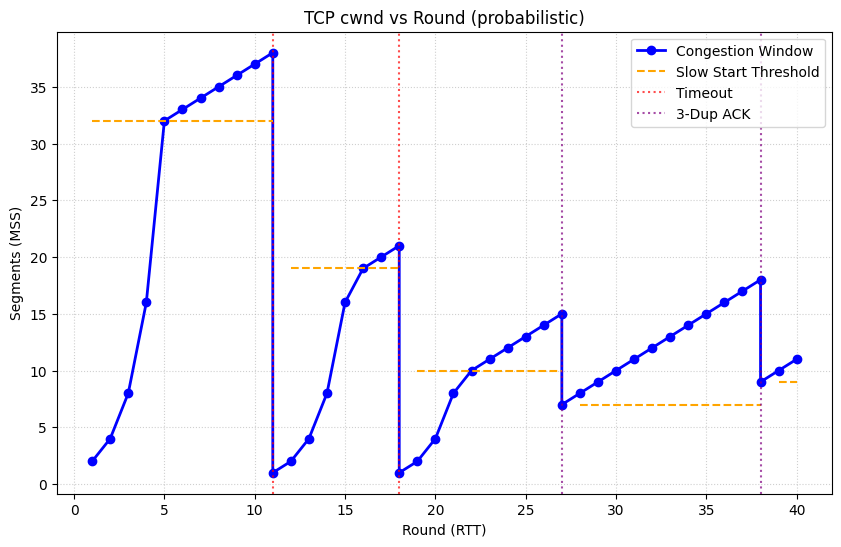


## Part 2A - Dijkstra / Link-State Routing (L3)

In this part, you will build a small link-state routing module based on Dijkstra's shortest-path algorithm.
Each router knows the full network graph and computes the cheapest routes to every other node.

Before you write any graded code, this section builds intuition with a tiny example.

### Demo - Dijkstra's algorithm: concept and tiny example

Think of the network as a weighted graph. Each node is a router, and each edge has a non-negative cost,
such as a distance or delay. For a chosen source node, Dijkstra's algorithm keeps track of the best cost
we currently know to every node and which neighbor we would go through to get there.

The algorithm maintains two main ideas:

dist[X] is our current best-known distance from the source to node X.
prev[X] is the predecessor of X on one best path (which node we came from to reach X).

At the start, all distances are set to infinity except the source, which has distance zero. Then we repeat:

1. Pick the unvisited node U with the smallest dist[U].
2. For each neighbor V of U, consider going source ->... -> U -> V.
  If this total cost is smaller than dist[V], update dist[V] and set prev[V] = U.
3. Mark U as visited and do not change it again.

After every reachable node has been visited, dist holds the shortest distances from the source,
and prev describes one shortest-path tree.

Here is a tiny example graph, using letters as router names and integers as link costs:

```python
example_graph = {
  'A': {'B': 2, 'C': 5},
  'B': {'A': 2, 'C': 1, 'D': 4},
  'C': {'A': 5, 'B': 1, 'D': 1},
  'D': {'B': 4, 'C': 1},
}
```

If we run Dijkstra from source 'A', the initial state is:

dist = {'A': 0, 'B': inf, 'C': inf, 'D': inf}
prev = {'A': None, 'B': None, 'C': None, 'D': None}

After visiting 'A', we learn that 'B' is distance 2 via 'A' and 'C' is distance 5 via 'A'.
After visiting 'B', we see that going A -> B -> C has cost 3, which is better than 5, so we update
dist['C'] = 3 and prev['C'] = 'B'. We also set dist['D'] = 6 and prev['D'] = 'B'.

You can continue in this style for 'C' and 'D'. When you are done, dist and prev describe one
shortest-path tree rooted at 'A'.

In the graded function step_table_function you will implement this algorithm in code. The step table
is just another way to look at the final dist and prev values for a given source.

Later in Part 2A you will use prev to decide, for each destination, which neighbor should be the first
hop from the source. That information becomes the forwarding table for that source.


In [7]:
def draw_weighted_graph(graph, path=None, title=None):
  """Helper function to visualize a weighted graph and (optionally) highlighting a path.

  This helper is not graded. It is only for your own exploration.
  """
  try:
    import networkx as nx
    import matplotlib.pyplot as plt
  except ImportError:
    print("draw_weighted_graph: requires networkx and matplotlib, which are optional.")
    return

  G = nx.Graph()
  for u, neighbors in graph.items():
    for v, w in neighbors.items():
      G.add_edge(u, v, weight=w)

  pos = nx.spring_layout(G, seed=0)
  edge_labels = nx.get_edge_attributes(G, 'weight')

  plt.figure(figsize=(5, 4))
  nx.draw_networkx(G, pos, with_labels=True, node_color="lightblue")
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  if path is not None and len(path) > 1:
    edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="red", width=2)

  if title:
    plt.title(title)
  plt.axis("off")
  plt.show()
  # Demo: Visualizing the tiny example graph from 2A.0


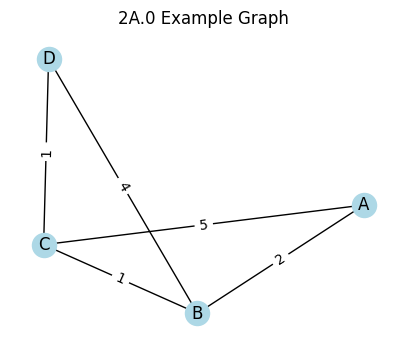

In [8]:
example_graph_2a0 = {
  'A': {'B': 2, 'C': 5},
  'B': {'A': 2, 'C': 1, 'D': 4},
  'C': {'A': 5, 'B': 1, 'D': 1},
  'D': {'B': 4, 'C': 1},
}

# This call shows how the graph looks.
draw_weighted_graph(example_graph_2a0, title="2A.0 Example Graph")


### 2A.1 - Dijkstra Step Table (10 Marks)

Implement a function that runs **Dijkstra's algorithm** from a single source node and returns the final
distance and predecessor dictionaries.

Graded function:

- Name: `step_table_function`
- Signature: `step_table_function(graph, source_node, INF=9999999)`

Inputs:

- `graph`: a dict where `graph[u][v]` gives the weight (cost) of edge `u2v`.
- `source_node`: the starting node label (for example `'A'`).

For the graded Part 2A problems, we will use the following fixed twelve-node graph:

```python
graph = {
  'A': {'G': 2, 'B': 5, 'D': 6},
  'B': {'A': 5, 'C': 4, 'D': 3, 'H': 6},
  'C': {'G': 2, 'J': 2, 'B': 4, 'I': 6},
  'D': {'A': 6, 'B': 3, 'E': 4, 'G': 8, 'H': 7, 'I': 5},
  'E': {'J': 2, 'K': 2, 'D': 4, 'H': 5},
  'F': {'G': 7, 'J': 5, 'K': 3, 'H': 4, 'I': 2, 'L': 9},
  'G': {'A': 2, 'C': 2, 'H': 3, 'F': 7, 'D': 8},
  'H': {'G': 3, 'E': 5, 'B': 6, 'L': 8, 'F': 4, 'D': 7},
  'I': {'C': 6, 'J': 3, 'K': 4, 'F': 2, 'D': 5},
  'J': {'C': 2, 'E': 2, 'I': 3, 'F': 5},
  'K': {'E': 2, 'L': 2, 'I': 4, 'F': 3},
  'L': {'K': 2, 'H': 8, 'F': 9}
}
  
```

Do not change this graph in your submission; you can, however, use it in your own tests and visualizations.

Return value:

- A tuple `(dist, prev)` where:
 - `dist` maps each node to its shortest distance from `source_node` (int; use a large value such as `math.inf` for unreachable nodes).
 - `prev` maps each node to its predecessor on one shortest path (use `None` for the source).

**Note:** The function should only compute and return `(dist, prev)`.


Example output shape (for illustration only):

```python
dist = {'S': 0, 'A': 3, 'B': 5}
prev = {'S': None, 'A': 'S', 'B': 'A'}
```

This shows the *shape* of the result: a dict of distances and a dict of predecessors.
The actual values in your assignment will depend on the graph and source node.


In [9]:
def step_table_function(graph, source_node, INF=9999999):
  """
  Compute Dijkstra's step table showing the state of distances at each iteration.
  This tracks the algorithm's progress as it finalizes the shortest path to each node.

  Parameters:
    graph (dict): Adjacency dictionary where graph[u][v] is the weight of edge u-v.
    source_node (str): The starting node identifier.


  Returns:
    tuple: A single tuple (dist, prev) containing the final distances and predecessor dictionary.
  """
  #initialize dist + prev
  nodes = list(graph.keys())
  dist = {node: INF for node in graph} # set all distances to infinity
  dist[source_node] = 0
  prev = {node: None for node in graph}

  visited = set() # da nodes that are visited
  #find next smallest distance
  for _ in range(len(nodes)):
    min_dist = INF #cmpring to this
    u = None
    #find the smallest distance
    for node in nodes:
      if node not in visited and dist[node] < min_dist:
        min_dist = dist[node]
        u = node

    #nothing reachable
    if u is None:
      break

    visited.add(u)

    #algorithm part
    if u in graph:
      #check neighbors
      for v,weight in graph[u].items():
        #neigbords visited?
        if v not in visited:
          new_dist = dist[u] + weight

          #is new path shorter?
          if new_dist < dist[v]:
            dist[v] = new_dist #update the shorter dist
            prev[v] = u #also the new previous
  return dist,prev

#testing DELETE THISS
graph = {
  'A': {'G': 2, 'B': 5, 'D': 6},
  'B': {'A': 5, 'C': 4, 'D': 3, 'H': 6},
  'C': {'G': 2, 'J': 2, 'B': 4, 'I': 6},
  'D': {'A': 6, 'B': 3, 'E': 4, 'G': 8, 'H': 7, 'I': 5},
  'E': {'J': 2, 'K': 2, 'D': 4, 'H': 5},
  'F': {'G': 7, 'J': 5, 'K': 3, 'H': 4, 'I': 2, 'L': 9},
  'G': {'A': 2, 'C': 2, 'H': 3, 'F': 7, 'D': 8},
  'H': {'G': 3, 'E': 5, 'B': 6, 'L': 8, 'F': 4, 'D': 7},
  'I': {'C': 6, 'J': 3, 'K': 4, 'F': 2, 'D': 5},
  'J': {'C': 2, 'E': 2, 'I': 3, 'F': 5},
  'K': {'E': 2, 'L': 2, 'I': 4, 'F': 3},
  'L': {'K': 2, 'H': 8, 'F': 9}
}
print(step_table_function(graph,'A'))


({'A': 0, 'B': 5, 'C': 4, 'D': 6, 'E': 8, 'F': 9, 'G': 2, 'H': 5, 'I': 9, 'J': 6, 'K': 10, 'L': 12}, {'A': None, 'B': 'A', 'C': 'G', 'D': 'A', 'E': 'J', 'F': 'G', 'G': 'A', 'H': 'G', 'I': 'J', 'J': 'C', 'K': 'E', 'L': 'K'})


### 2A.2 - Forwarding Table (5 Marks)

Using the `prev` dictionary from Dijkstra's algorithm, determine the **next hop** for
a single source node.

Graded function:

- Name: `forwarding_table_function`
- Signature: `forwarding_table_function(prev, destination)`


Inputs:

- `prev`: the predecessor dictionary from the `(dist, prev)` tuple returned by `step_table_function`.

- `destination`: the destination node.


Return value:\n
\n
- The immediate **next hop** node (string) from the source to the specified `destination`.\n
  - The source node is the unique node whose entry in `prev` is `None`.\n
  - If `destination` is this source node, return `'-'`.\n
  - Otherwise, follow `prev[destination]` backwards until you reach the source, then\n
    return the node immediately after the source on that path.\n
Example output:

```python
next_hop = 'A' # The immediate neighbor to send to
```

The source node is the unique node whose entry in `prev` is `None`.\n If `destination` is this source node, return `'-'`.\n Otherwise, follow `prev[destination]` backwards until you reach the source, then return the node immediately after the source on that path.


In [10]:
def forwarding_table_function(prev, destination):

  """
  Compute the forwarding table (next hop) from source to destination using the predecessor map.

  The source node is the unique node whose entry in `prev` is None. If `destination` is\n  this source node, the function should return '-'. Otherwise, it should trace backwards\n  from `destination` using `prev` and return the node immediately after the source on\n  that shortest path.\n


  Parameters:
    prev (dict): Predecessor map where prev[node] is the previous node in the shortest path.

    destination (str): The target destination node.



  Returns:
    str: The immediate next hop node (e.g., 'B') or '-' if destination is source.
  """
  #find src

  srcNode = None
  for node, prevNode in prev.items():
    if prevNode is None:
      srcNode = node
      break

  #dest = src return "="
  if destination == srcNode:
    return "-"

  #return next hop
  #start from destination go backwards
  currHop = destination
  nextHop = destination
  while currHop is not srcNode: #currHop is not None means it will continue until it reaches source node where prev[nextHop] is None
    nextHop = currHop
    currHop = prev[nextHop]

  return nextHop

#testing DELETE THISS
graph = {
  'A': {'G': 2, 'B': 5, 'D': 6},
  'B': {'A': 5, 'C': 4, 'D': 3, 'H': 6},
  'C': {'G': 2, 'J': 2, 'B': 4, 'I': 6},
  'D': {'A': 6, 'B': 3, 'E': 4, 'G': 8, 'H': 7, 'I': 5},
  'E': {'J': 2, 'K': 2, 'D': 4, 'H': 5},
  'F': {'G': 7, 'J': 5, 'K': 3, 'H': 4, 'I': 2, 'L': 9},
  'G': {'A': 2, 'C': 2, 'H': 3, 'F': 7, 'D': 8},
  'H': {'G': 3, 'E': 5, 'B': 6, 'L': 8, 'F': 4, 'D': 7},
  'I': {'C': 6, 'J': 3, 'K': 4, 'F': 2, 'D': 5},
  'J': {'C': 2, 'E': 2, 'I': 3, 'F': 5},
  'K': {'E': 2, 'L': 2, 'I': 4, 'F': 3},
  'L': {'K': 2, 'H': 8, 'F': 9}
}
dist,prev = step_table_function(graph,'F')
print(prev)
print(forwarding_table_function(prev,'D'))

{'A': 'G', 'B': 'H', 'C': 'J', 'D': 'I', 'E': 'K', 'F': None, 'G': 'F', 'H': 'F', 'I': 'F', 'J': 'F', 'K': 'F', 'L': 'K'}
I


### 2A.3 - Shortest Path (5 Marks)

This function will construct the shortest path from a source node to a destination node based on the predecessor map `prev`.
The output path should be an ordered list of nodes starting at the source and ending at the destination.

In networks, when a packet arrives, each node checks its forwarding table to find the next node (toward the destination node), and then forwards the packet to the corresponding next node.

**Task**:
1. Implement `Dijkstra_shortest_path`.
2. **Visualizing**: Plot the shortest path from **Node A** (Source) to **Node F** (Destination) using the provided `visualize` helper.

#### Graded Function
- **Name**: `Dijkstra_shortest_path`
- **Signature**: `Dijkstra_shortest_path(prev, destination)`
- **Inputs**:
 - `prev`: Predecessor dictionary where `prev[node]` is the previous node in the shortest path.

 - `destination`: The target destination node label.
- **Returns**: A list representing the full path from the source to the destination (e.g., `['A', 'B', 'C', 'F']`).
- **Constraints**:

#### Helper Function (Provided)
We have provided a helper function to visualize your results:
- **Name**: `visualize`
- **Signature**: `visualize(graph, path=None, title="Graph")`
- **Usage**: Use this in the "Example Usage" section to plot the path returned by your function.


['A', 'G', 'F']


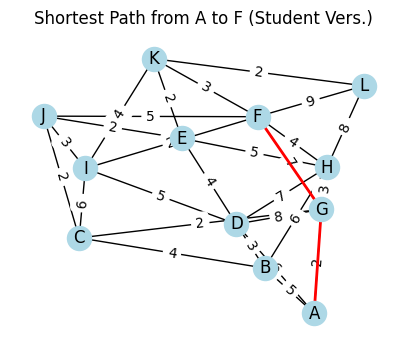

In [11]:
def Dijkstra_shortest_path(prev, destination):
  """
  Reconstruct the full shortest path from source to destination using the predecessor map.
  Backtracks from the destination to the source to build the path sequence.

  Parameters:
    prev (dict): Predecessor map where prev[node] is the previous node in the optimal path.
    destination (str): The target node identifier.

  Returns:
    list: A list of nodes representing the shortest path (source, ..., destination).

  """
  #find src
  srcNode = None
  for node, prevNode in prev.items():
    if prevNode is None:
      srcNode = node
      break

  path = []
  currHop = destination
  while currHop is not srcNode: #currHop is not None means it will continue until it reaches source node where prev[currHop] is None
    path.insert(0,currHop) #insert at beginning since we are adding nodes backwards
    currHop = prev[currHop]

  path.insert(0,srcNode) #while stops at src so we have to add outside
  return path

def draw_weighted_graph(graph, path=None, title=None):
  """Helper function to visualize a weighted graph and (optionally) highlighting a path.

  This helper is not graded. It is only for your own exploration.
  """
  try:
    import networkx as nx
    import matplotlib.pyplot as plt
  except ImportError:
    print("draw_weighted_graph: requires networkx and matplotlib, which are optional.")
    return

  G = nx.Graph()
  for u, neighbors in graph.items():
    for v, w in neighbors.items():
      G.add_edge(u, v, weight=w)

  pos = nx.spring_layout(G, seed=0)
  edge_labels = nx.get_edge_attributes(G, 'weight')

  plt.figure(figsize=(5, 4))
  nx.draw_networkx(G, pos, with_labels=True, node_color="lightblue")
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  if path is not None and len(path) > 1:
    edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="red", width=2)

  if title:
    plt.title(title)
  plt.axis("off")
  plt.show()
  # Demo: Visualizing the tiny example graph from 2A.0

graph = {
  'A': {'G': 2, 'B': 5, 'D': 6},
  'B': {'A': 5, 'C': 4, 'D': 3, 'H': 6},
  'C': {'G': 2, 'J': 2, 'B': 4, 'I': 6},
  'D': {'A': 6, 'B': 3, 'E': 4, 'G': 8, 'H': 7, 'I': 5},
  'E': {'J': 2, 'K': 2, 'D': 4, 'H': 5},
  'F': {'G': 7, 'J': 5, 'K': 3, 'H': 4, 'I': 2, 'L': 9},
  'G': {'A': 2, 'C': 2, 'H': 3, 'F': 7, 'D': 8},
  'H': {'G': 3, 'E': 5, 'B': 6, 'L': 8, 'F': 4, 'D': 7},
  'I': {'C': 6, 'J': 3, 'K': 4, 'F': 2, 'D': 5},
  'J': {'C': 2, 'E': 2, 'I': 3, 'F': 5},
  'K': {'E': 2, 'L': 2, 'I': 4, 'F': 3},
  'L': {'K': 2, 'H': 8, 'F': 9}
}
dist,prev = step_table_function(graph,'A')
path = Dijkstra_shortest_path(prev,'F')
print(path)
draw_weighted_graph(graph,path,"Shortest Path from A to F (Student Vers.)")


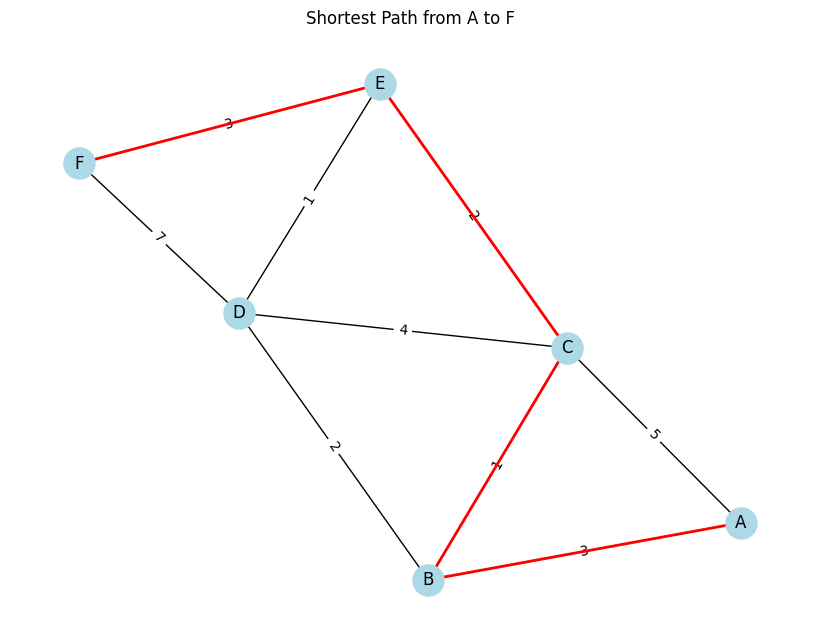


Before you implement `simulate_packet`, it is helpful to think through one tiny Time To Live (TTL) example by hand.

Suppose the intended path is

```python
path = ['A', 'B', 'C', 'D']
```

and the initial TTL is 2. You start at 'A' with TTL 2.

- Hop 1: move to 'B'. After this hop, TTL becomes 1.
- Hop 2: move to 'C'. After this hop, TTL becomes 0.

At this point the packet stops at 'C' and never reaches 'D'. In this situation your function should return

- success = False (the packet did not reach the final node in the path),
- final_node = 'C',
- traveled_path = ['A', 'B', 'C'].

If we used a larger TTL, for example 3 or 4, the packet would survive long enough to reach 'D', and `success` would be True.

Your implementation of `simulate_packet(path, ttl)` should follow this kind of reasoning step by step, without printing anything.


### 2A.4 - Packet Simulation with TTL (10 Marks)

Now you will simulate a packet traversing a given path using a **Time To Live (TTL)** value.
You are required to **visualize two separate graphs** corresponding to the following test cases using the provided 12-node graph:

1. **Case 1**: Source **A** to Destination **L** with **TTL = 3**.
2. **Case 2**: Source **B** to Destination **L** with **TTL = 8**.

#### Graded Function
- **Name**: `simulate_packet`
- **Signature**: `simulate_packet(path, ttl)`
- **Inputs**:
 - `path`: list of nodes representing the intended route of the packet.
 - `ttl`: integer initial TTL value; decremented at each hop.
- **Returns**: A tuple `(success, final_node, traveled_path)` where:
 - `success` is `True` if the packet reaches the final node in `path` before TTL expires; otherwise `False`.
 - `final_node` is the last node visited.
 - `traveled_path` is the list of nodes actually visited.
- **Constraints**:

#### Helper Function (Provided)
We have provided a helper function to visualize your results:
- **Name**: `visualize`
- **Signature**: `visualize(graph, path=None, title="Graph")`
- **Description**: Plots the given `graph` using NetworkX. If a `path` list is provided, the edges along that path are highlighted in red.
- **Usage**: Call this function **twice** in the "Example Usage" section—once for each test case—to produce the two required plots.


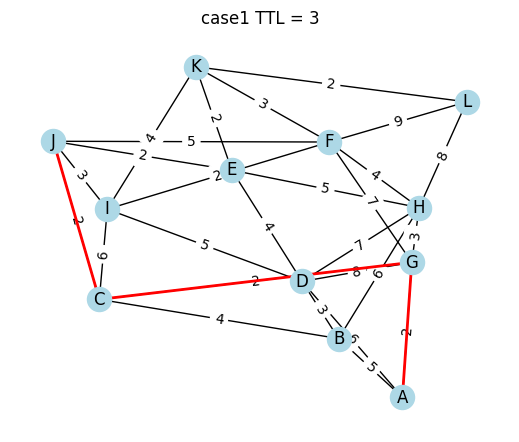

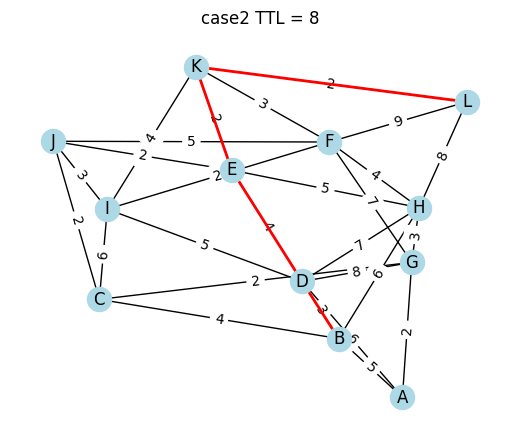

In [23]:
def simulate_packet(path, ttl):
  """
  Simulate a packet traversal along a given path using a Time To Live (TTL) mechanism.
  At each hop along `path`, decrement TTL by 1 *after* moving to the next node. If TTL\n  reaches 0 before the destination is reached, the packet stops and is considered to\n  have expired at the current node.\n

  Parameters:
    path (list): The ordered list of nodes the packet intends to traverse.
    ttl (int): Initial Time To Live value.

  Returns:
    tuple: (success, final_node, traveled_path) where success is True if destination reached.
  """

  success = False
  final_node = path[0]
  traveled_path = [path[0]]

  #only loop for as long as path
  for i in range(1, len(path)):
    if ttl <= 0:
      break
    final_node = path[i]
    traveled_path.append(final_node)

    ttl -= 1

  if final_node == path[-1]:
    success = True
  return success, final_node, traveled_path

  # --- Student Code End ---

def draw_weighted_graph(graph, path=None, title=None):
  """Helper function to visualize a weighted graph and (optionally) highlighting a path.

  This helper is not graded. It is only for your own exploration.
  """
  try:
    import networkx as nx
    import matplotlib.pyplot as plt
  except ImportError:
    print("draw_weighted_graph: requires networkx and matplotlib, which are optional.")
    return

  G = nx.Graph()
  for u, neighbors in graph.items():
    for v, w in neighbors.items():
      G.add_edge(u, v, weight=w)

  pos = nx.spring_layout(G, seed=0)
  edge_labels = nx.get_edge_attributes(G, 'weight')

  plt.figure(figsize=(5, 4))
  nx.draw(G, pos, with_labels=True, node_color="lightblue")
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  if path is not None and len(path) > 1:
    edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="red", width=2)

  if title:
    plt.title(title)
  plt.axis("off")
  plt.show()
  # Demo: Visualizing the tiny example graph from 2A.0

graph = {
  'A': {'G': 2, 'B': 5, 'D': 6},
  'B': {'A': 5, 'C': 4, 'D': 3, 'H': 6},
  'C': {'G': 2, 'J': 2, 'B': 4, 'I': 6},
  'D': {'A': 6, 'B': 3, 'E': 4, 'G': 8, 'H': 7, 'I': 5},
  'E': {'J': 2, 'K': 2, 'D': 4, 'H': 5},
  'F': {'G': 7, 'J': 5, 'K': 3, 'H': 4, 'I': 2, 'L': 9},
  'G': {'A': 2, 'C': 2, 'H': 3, 'F': 7, 'D': 8},
  'H': {'G': 3, 'E': 5, 'B': 6, 'L': 8, 'F': 4, 'D': 7},
  'I': {'C': 6, 'J': 3, 'K': 4, 'F': 2, 'D': 5},
  'J': {'C': 2, 'E': 2, 'I': 3, 'F': 5},
  'K': {'E': 2, 'L': 2, 'I': 4, 'F': 3},
  'L': {'K': 2, 'H': 8, 'F': 9}
}
dist,prev = step_table_function(graph,'A')
path = Dijkstra_shortest_path(prev,'L')

success,finalNode,case1Path = simulate_packet(path,ttl=3)
dist,prev = step_table_function(graph,'B')
path = Dijkstra_shortest_path(prev,'L')
success,finalNode,case2Path = simulate_packet(path,ttl=8)
draw_weighted_graph(graph,case1Path,"case1 TTL = 3")
draw_weighted_graph(graph,case2Path,"case2 TTL = 8")


---


## Part 2B — Distance Vector Routing (L3)

In this part, you will implement a distributed routing protocol based on the **Bellman-Ford** algorithm,
also known as **Distance Vector (DV) routing**. Unlike link-state routing where each router has
the complete network topology, in distance vector routing each router only knows:

1. The cost to its **direct neighbors**
2. Distance vectors **received from those neighbors**

Each router maintains a table showing the best-known distance to every destination and which
neighbor to use as the next hop. Routers periodically exchange their distance vectors with
neighbors, and each router updates its own table based on the **Bellman-Ford equation**:

```
dist[X][Y] = min over all neighbors N of:  cost(X,N) + dist[N][Y]
```

In plain English: The best cost from X to Y is the minimum of: my cost to neighbor N, plus N's advertised cost to Y.

### Key Differences from Link-State (Dijkstra)

- **Link-State:** Each router has the full network graph and runs Dijkstra locally.
- **Distance Vector:** Each router only knows costs to neighbors and relies on updates from them.

### How Distance Vector Works

1. **Initialization:** Each router sets distance 0 to itself, direct link cost to neighbors, and infinity (∞) to all other destinations.
2. **Exchange:** Routers send their distance vectors to all neighbors.
3. **Update:** Each router applies the Bellman-Ford equation to potentially improve routes.
4. **Repeat:** Steps 2-3 continue until the network converges (no more updates).

### Example Graph

We'll use this 4-node network for all Part 2B tasks:

```python
dv_graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 7},
    'C': {'A': 4, 'B': 2, 'D': 3},
    'D': {'B': 7, 'C': 3}
}
```

**Initial state** (before any exchanges): Each router only knows direct neighbors:

- A: knows cost 1 to B, cost 4 to C, ∞ to D
- B: knows cost 1 to A, cost 2 to C, cost 7 to D
- C: knows cost 4 to A, cost 2 to B, cost 3 to D
- D: knows ∞ to A, cost 7 to B, cost 3 to C

After exchanging vectors, routers learn better paths. For example, A will discover that it can reach D via B with total cost 1+7=8, or via C with cost 4+3=7 (better!).



### Distance Vector Routing Table

Before you begin coding, fill out the Distance Vector table below based on the `dv_graph` provided.
This will help you visualize the initial distances and understand how the algorithm propagates updates.

**Graph:**
*   A: {B: 1, C: 4}
*   B: {A: 1, C: 2, D: 7}
*   C: {A: 4, B: 2, D: 3}
*   D: {B: 7, C: 3}

**Distance Vector Table (Initial State - Neighbors Only):**

| Node | Distance to A | Distance to B | Distance to C | Distance to D |
| :--- | :---: | :---: | :---: | :---: |
| **A** | 0 | 1 | 4 | ∞ |
| **B** | 1 | 0 | 2 | 7 |
| **C** | 4 | 2 | 0 | 3 |
| **D** | ∞ | 7 | 3 | 0 |

*(Note: This table shows direct link costs. In the actual algorithm, nodes exchange these vectors to compute shortest paths via neighbors.)*


### 2B.1 - Initialize distance-vector tables (5 Marks)

Initialize distance-vector routing tables for all routers in a graph.

Graded function:

- Name: `initialize_routing_tables`
- Signature: `initialize_routing_tables(graph, INF=9999999)`

Inputs:

- `graph`: adjacency dict where `graph[X][Y]` gives the cost of the edge from X to Y.
- `INF`: a large number representing "infinity" for unreachable destinations (default `9999999`).

Return value:

- A dict `routing_tables` mapping each router X to a dict with keys `'dist'` and `'next'`:
 - `routing_tables[X]['dist'][Y]`: cost from X to Y (0 for X itself, direct edge cost for neighbors, or INF otherwise).
 - `routing_tables[X]['next'][Y]`: next hop from X to Y (X for itself, Y for direct neighbors, or `None` otherwise).


Example output shape (for illustration only):

```python
routing_tables = {
  'A': {
    'dist': {'A': 0, 'B': 2, 'C': 9999999},
    'next': {'A': 'A', 'B': 'B', 'C': None},
  },
  'B': {
    'dist': {'A': 2, 'B': 0, 'C': 5},
    'next': {'A': 'A', 'B': 'B', 'C': 'C'},
  },
}
```

Each router key maps to a dict with 'dist' and 'next' sub-dicts.



In [13]:
def initialize_routing_tables(graph, INF=9999999):
  """
  Build the initial distance vector routing tables for all routers in the graph.
  Each node starts knowing only the cost to itself (0) and its direct neighbors.

  Parameters:
    graph (dict): Adjacency dictionary representing the network.
    INF (int): Value representing infinity for unknown paths.

  Returns:
    dict: Nested dictionary routing_tables[node]['dist'/'next'][destination].
  """
  routing_tables = {}
  #make all the routers in the table
  for x in graph.keys():
    routing_tables[x] = {'dist': {}, 'next': {}}
    #get list of neighbors for x
    neighbors = graph.get(x,{})
    for y in graph.keys():
      #Case 1 X -> Y is the same
      if x == y:
        routing_tables[x]['dist'][y] = 0
        routing_tables[x]['next'][y] = x
      #Case 2 X -> Y is possible
      elif y in neighbors:
        #cost of going from x -> y
        cost = neighbors[y]
        routing_tables[x]['dist'][y] = cost
        routing_tables[x]['next'][y] = y
      #Case 3 X -> Y not possible
      else:
        routing_tables[x]['dist'][y] = INF
        routing_tables[x]['next'][y] = None

  return routing_tables

#TESTING DELETE THIS
dv_graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 7},
    'C': {'A': 4, 'B': 2, 'D': 3},
    'D': {'B': 7, 'C': 3}
}

routing_table = initialize_routing_tables(dv_graph)
print(routing_table)




{'A': {'dist': {'A': 0, 'B': 1, 'C': 4, 'D': 9999999}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': None}}, 'B': {'dist': {'A': 1, 'B': 0, 'C': 2, 'D': 7}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'C': {'dist': {'A': 4, 'B': 2, 'C': 0, 'D': 3}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'D': {'dist': {'A': 9999999, 'B': 7, 'C': 3, 'D': 0}, 'next': {'A': None, 'B': 'B', 'C': 'C', 'D': 'D'}}}


### 2B.2 - Distance Vector Round (5 Marks)

Implement one synchronous **distance-vector round** (Bellman-Ford update) over all routers.

Graded function:

- Name: `distance_vector_round`
- Signature: `distance_vector_round(graph, routing_tables, INF=9999999)`

Inputs:

- `graph`: adjacency dict with edge weights.
- `routing_tables`: current routing tables for all routers (as returned by `initialize_routing_tables`).
- `INF`: value representing "infinity" for unreachable destinations.

Return value:

- A tuple `(new_routing_tables, changed)` where:
 - `new_routing_tables` is the updated routing_tables after one synchronous Bellman-Ford round.
 - `changed` is `True` if any distance entry changed in this round, otherwise `False`.



Example output shape (for illustration only):

```python
new_routing_tables, changed = distance_vector_round(graph, routing_tables)

# new_routing_tables has the same nested structure as routing_tables
# changed is a bool, e.g. True if any distance improved in this round.
```


In [14]:
def distance_vector_round(graph, routing_tables, INF=9999999):
  """
  Run one synchronous round of the Bellman-Ford algorithm for all routers.
  Nodes exchange distance vectors with neighbors and update their own tables if a shorter path is found.

  Parameters:
    graph (dict): The network topology.
    routing_tables (dict): Current state of routing tables for all nodes.


  Returns:
    tuple: (new_routing_tables, changed_flag), where changed_flag is True if any update occurred.
  """
  #copy the table structure
  newRoutingTables = {}
  changed = False
  for x in graph.keys():
    newRoutingTables[x] = {
      'dist':routing_tables[x]['dist'].copy(),
      'next':routing_tables[x]['next'].copy()
    }


  for x in graph.keys():
    for y in graph.keys():
      #check updates
      currDist = routing_tables[x]['dist'][y]
      minNewDist = currDist
      bestNextHop = routing_tables[x]['next'][y]
      for neighborZ in graph.get(x,{}):
        #cost of x -> neighbor
        costXtoZ = graph[x][neighborZ]

        if y in routing_tables[neighborZ]['dist']:
          distZtoY = routing_tables[neighborZ]['dist'][y]
        else:
          distZtoY = INF

        #only consider if neighbor has a path to Y
        if distZtoY != INF:
          newPathCost = costXtoZ + distZtoY

          #is this path better?
          if newPathCost < minNewDist:
            minNewDist = newPathCost
            bestNextHop = neighborZ
      #apply update if sorter path is found
      if minNewDist < currDist:
        newRoutingTables[x]['dist'][y] = minNewDist
        newRoutingTables[x]['next'][y] = bestNextHop
        changed = True
  return newRoutingTables,changed


#TESTING DELETE THIS
dv_graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 7},
    'C': {'A': 4, 'B': 2, 'D': 3},
    'D': {'B': 7, 'C': 3}
}

routing_table = initialize_routing_tables(dv_graph)
print(routing_table)
next_round_table ,flag = distance_vector_round(dv_graph,routing_table)
print(flag)
print(next_round_table)




{'A': {'dist': {'A': 0, 'B': 1, 'C': 4, 'D': 9999999}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': None}}, 'B': {'dist': {'A': 1, 'B': 0, 'C': 2, 'D': 7}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'C': {'dist': {'A': 4, 'B': 2, 'C': 0, 'D': 3}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'D': {'dist': {'A': 9999999, 'B': 7, 'C': 3, 'D': 0}, 'next': {'A': None, 'B': 'B', 'C': 'C', 'D': 'D'}}}
True
{'A': {'dist': {'A': 0, 'B': 1, 'C': 3, 'D': 7}, 'next': {'A': 'A', 'B': 'B', 'C': 'B', 'D': 'C'}}, 'B': {'dist': {'A': 1, 'B': 0, 'C': 2, 'D': 5}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'C'}}, 'C': {'dist': {'A': 3, 'B': 2, 'C': 0, 'D': 3}, 'next': {'A': 'B', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'D': {'dist': {'A': 7, 'B': 5, 'C': 3, 'D': 0}, 'next': {'A': 'C', 'B': 'C', 'C': 'C', 'D': 'D'}}}


### 2B.3 - Link Cost Change (5 Marks)


**Concept:**
Link cost change occurs when the metric associated with a link increases or decreases (e.g., due to congestion or bandwidth changes). In distance-vector routing, nodes must detect this change, update their local distance vectors, and propagate the new information to neighbors to ensure routing tables converge to the new shortest paths.

Simulate a **link-cost change** in the distance-vector network and propagate updates until convergence.

Graded function:

- Name: `apply_link_cost_change`
- Signature: `apply_link_cost_change(graph, routing_tables, u, v, new_cost, INF=9999999)`

Inputs:

- `graph`: the distance-vector graph adjacency dict.
- `routing_tables`: current routing tables for all routers.
- `u`, `v`: endpoints of the link whose cost is changing.
- `new_cost`: new cost of the undirected edge between `u` and `v`.
- `INF`: value representing "infinity" for unreachable destinations.

Return value:

- The converged `routing_tables` after the link-cost change has been applied and propagated.

This function is graded. It should only update data structures and return them.

Example output shape (for illustration only):

```python
updated_tables = apply_link_cost_change(graph, routing_tables, 'A', 'B', new_cost=7)

# updated_tables has the same nested structure as routing_tables,
# but some distances and next hops may have changed after convergence.
```




In [15]:
def apply_link_cost_change(graph, routing_tables, u, v, new_cost, INF=9999999):
  """
  Apply a change to a link's cost and run the Distance Vector algorithm until convergence.
  Simulates the network's reaction to topology changes.

  Parameters:
    graph (dict): The network topology.
    routing_tables (dict): Current routing tables.
    u (str): One end of the link.
    v (str): The other end of the link.
    new_cost (int): The new weight for the link u-v.


  Returns:
    dict: The final converged routing tables.
  """
  #delete links if needed
  if new_cost == INF:
    if u in graph and v in graph[u]:
      del graph[u][v]
    if v in graph and u in graph[v]:
      del graph[v][u]
  else:
    #update the cost of u -> v and v -> u
    if u in graph:
      graph[u][v] = new_cost
    if v in graph:
      graph[v][u] = new_cost

  #we keep doing rounds aka updating until no changes are made
  changed = True
  curr_routing_table = routing_tables
  while changed:
    curr_routing_table,changed = distance_vector_round(graph,curr_routing_table)

  return curr_routing_table


#TESTING DELETE THIS
dv_graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 7},
    'C': {'A': 4, 'B': 2, 'D': 3},
    'D': {'B': 7, 'C': 3}
}

routing_table = initialize_routing_tables(dv_graph)
newCost = 1
u,v = 'B','D'
changedTable = apply_link_cost_change(dv_graph,routing_table,u,v,newCost)
print(changedTable)




{'A': {'dist': {'A': 0, 'B': 1, 'C': 3, 'D': 2}, 'next': {'A': 'A', 'B': 'B', 'C': 'B', 'D': 'B'}}, 'B': {'dist': {'A': 1, 'B': 0, 'C': 2, 'D': 1}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'C': {'dist': {'A': 3, 'B': 2, 'C': 0, 'D': 3}, 'next': {'A': 'B', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'D': {'dist': {'A': 2, 'B': 1, 'C': 3, 'D': 0}, 'next': {'A': 'B', 'B': 'B', 'C': 'C', 'D': 'D'}}}


### Expected Output (Visualization)

**Initial Graph:**


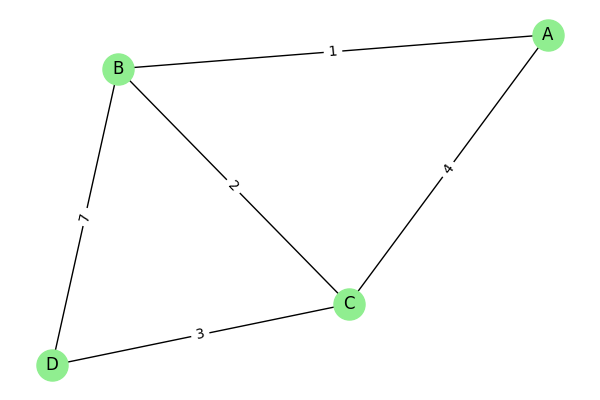

**After Link Cost Change (A-B = 10):**


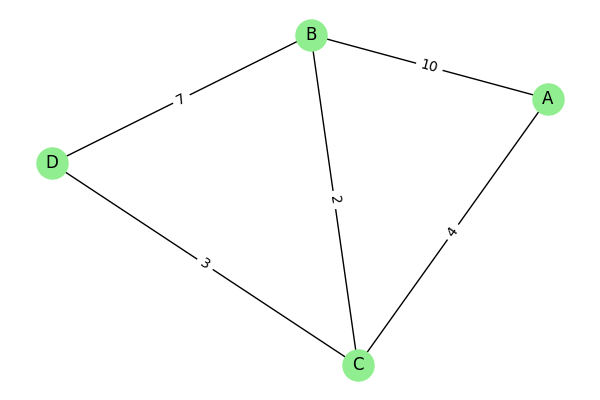


### 2B.4 - Link Loss (5 Marks)


**Concept:**
Link loss is a specific case of link cost change where the cost becomes infinite (effectively breaking the link). This simulates a cable cut or node failure. Handling this requires the protocol to find alternative paths, often involving a re-convergence process that can be slow without mechanisms like Split Horizon or Poison Reverse (count-to-infinity problem).

In distance-vector routing, when a link fails (or its cost becomes infinite), nodes must update their tables.
This often triggers the "count-to-infinity" problem if poison reverse or split horizon is not used.

**Task:**
Implement `apply_link_loss(graph, routing_tables, u, v, INF)`.

**Behavior:**
1.  Update the graph to reflect that the link `u-v` (and `v-u`) now has cost `INF`.
2.  Update `routing_tables[u]['dist'][v]` and `routing_tables[v]['dist'][u]` to `INF`.
3.  Starting from the updated routing_tables, run `distance_vector_round` repeatedly until convergence (i.e., until it returns `changed == False`).
4.  Return the final converged `routing_tables`.

**Function Signature:**
`apply_link_loss(graph, routing_tables, u, v, INF=9999999)`

*(Note: This simulates the network reacting to a failure and finding new paths.)*



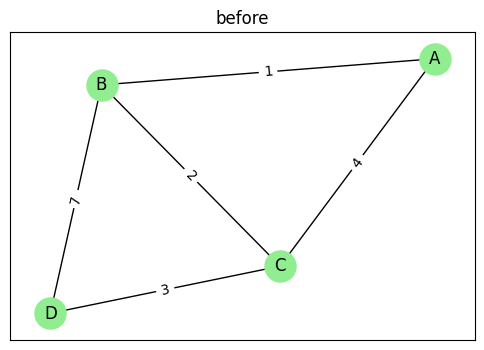

{'A': {'dist': {'A': 0, 'B': 6, 'C': 4, 'D': 7}, 'next': {'A': 'A', 'B': 'C', 'C': 'C', 'D': 'C'}}, 'B': {'dist': {'A': 6, 'B': 0, 'C': 2, 'D': 5}, 'next': {'A': 'C', 'B': 'B', 'C': 'C', 'D': 'C'}}, 'C': {'dist': {'A': 4, 'B': 2, 'C': 0, 'D': 3}, 'next': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'}}, 'D': {'dist': {'A': 7, 'B': 5, 'C': 3, 'D': 0}, 'next': {'A': 'C', 'B': 'C', 'C': 'C', 'D': 'D'}}}


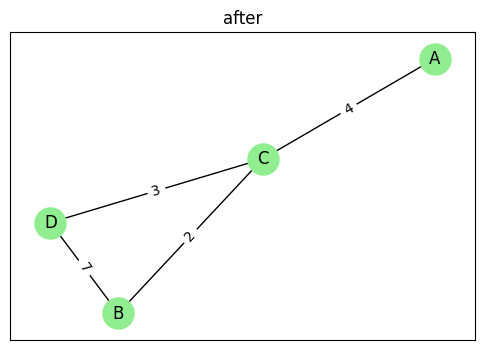

In [16]:
# Fixed four-node graph for Part 2B
dv_graph = {
  'A': {'B': 1, 'C': 4},
  'B': {'A': 1, 'C': 2, 'D': 7},
  'C': {'A': 4, 'B': 2, 'D': 3},
  'D': {'B': 7, 'C': 3},
}
INF = 9999999

import networkx as nx
import matplotlib.pyplot as plt

def visualize_dv_graph(graph, title="DV Graph"):
  """
  Visualize the Distance Vector graph topology.
  Uses NetworkX to draw nodes and weighted edges.

  Parameters:
    graph (dict): Adjacency dictionary representing the network.
    title (str): Title of the plot.

  Returns:
    None: Displays the graph plot.
  """
  G = nx.Graph()
  for node, neighbors in graph.items():
    for neighbor, weight in neighbors.items():
      if not G.has_edge(node, neighbor):
        G.add_edge(node, neighbor, weight=weight)

  pos = nx.spring_layout(G, seed=42)
  plt.figure(figsize=(6, 4))
  nx.draw_networkx(G, pos, with_labels=True, node_color="lightgreen", node_size=500)
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  plt.title(title)
  plt.show()

def apply_link_loss(graph, routing_tables, u, v, INF=9999999):
  """
  Simulate the failure of a link and propagate updates until convergence.
  Sets the link cost to infinity to model a broken connection.

  Parameters:
    graph (dict): The network topology.
    routing_tables (dict): Current routing tables.
    u (str): One end of the link.
    v (str): The other end of the link.


  Returns:
    dict: The final converged routing tables (demonstrating count-to-infinity if applicable).
  """
  if u in graph and v in graph[u]:
    del graph[u][v]
  if v in graph and u in graph[v]:
    del graph[v][u]

  #update routing tables for INF link
  if u in routing_tables and v in routing_tables[u]['dist']:
    routing_tables[u]['dist'][v] = INF
    routing_tables[u]['next'][v] = None
  if v in routing_tables and u in routing_tables[v]['dist']:
    routing_tables[v]['dist'][u] = INF
    routing_tables[v]['next'][u] = None

  #now keep making rounds until no change
  changed = True
  curr_routing_table = routing_tables
  while changed:
    curr_routing_table, changed = distance_vector_round(graph,curr_routing_table)

  return curr_routing_table

#TESTING DELETE THIS
dv_graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'A': 1, 'C': 2, 'D': 7},
    'C': {'A': 4, 'B': 2, 'D': 3},
    'D': {'B': 7, 'C': 3}
}

routing_table = initialize_routing_tables(dv_graph)
visualize_dv_graph(dv_graph, "before")
newCost = 1
u,v = 'B','D'
changedTable = apply_link_loss(dv_graph,routing_table,'A','B')
print(changedTable)
visualize_dv_graph(dv_graph,"after")




### Expected Output (Visualization)

**After Link Loss (Remove A-B):**


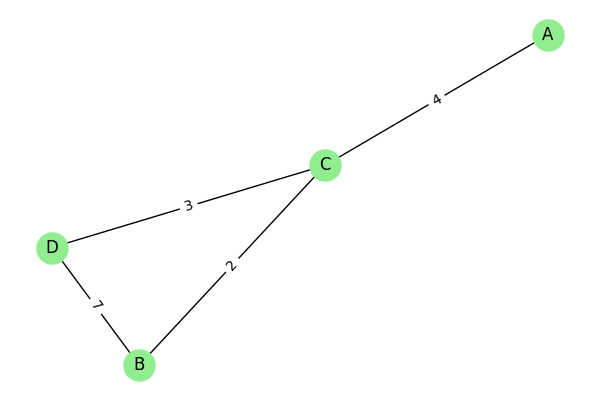


## Part 3 — Slotted ALOHA MAC and CRC (L2)

In this part, you will:

- Simulate an idealized **slotted ALOHA** multiple-access channel.
- Explore how throughput depends on the transmission probability `p`.
- Implement bit-level **CRC generation** and **CRC error detection**.

All functionality in this part is implemented as Python functions in this notebook so the autograder can import and test them directly.


### 3.1 - Slotted ALOHA Simulation (5 Marks)

In this problem you will implement a Monte Carlo simulation of the idealized slotted ALOHA model.

Model assumptions:

- `num_users` identical users share one channel.
- Time is divided into slots; one packet takes exactly one slot to send.
- In each slot, each user transmits a packet independently with probability `p`.

In each slot there are three possible outcomes:

- **Success:** exactly one user transmits.
- **Collision:** two or more users transmit.
- **Idle:** no one transmits.

**Graded function - simulation**

- Name: `simulate_slotted_aloha`
- Signature: `simulate_slotted_aloha(num_users, p, num_slots, seed=None)`
- Return type: `dict` with the following keys:
 - `'num_users'` (int)
 - `'p'` (float)
 - `'num_slots'` (int)
 - `'successes'` (int) - number of successful slots
 - `'collisions'` (int) - number of collision slots
 - `'idle_slots'` (int) - number of idle slots
 - `'throughput'` (float) - `successes / num_slots`.

The counts must satisfy `successes + collisions + idle_slots == num_slots`.

Randomness requirements:

- If `seed is not None`, use a local random number generator, e.g. `rng = random.Random(seed)`, and draw all random numbers from it.
- If `seed is None`, you may use the global `random` module.



Example output shape (for illustration only):

```python
results = {
  "num_users":  10,
  "p":      0.1,
  "num_slots":  10000,
  "successes":  743,
  "collisions": 1200,
  "idle_slots": 8057,
  "throughput": 0.0743,
}
```


In [17]:
import random


def simulate_slotted_aloha(num_users, p, num_slots, seed=None):
  """
  Simulate the Slotted ALOHA MAC protocol for a fixed number of time slots.
  Tracks successful transmissions, collisions, and idle slots based on user probability.

  Parameters:
    num_users (int): Total number of users attempting to transmit.
    p (float): Probability that a user transmits in a given slot.
    num_slots (int): Total number of time slots to simulate.
    seed (int, optional): Random seed for reproducibility.

  Returns:
    dict: Results containing 'num_users', 'p', 'num_slots', 'successes', 'collisions', 'idle_slots', and 'throughput'.
  """
  #random
  if seed is not None:
    rng = random.Random(seed)
  else:
    rng = random

  successes, collisions, idle_slots = 0,0,0
  #simulate da slots
  for _ in range(num_slots):
    #flip coins as many times as users
    transmissions = 0
    for _ in range(num_users):
      #does user transmit? independent chance so every user tries to send
      if rng.random() < p:
        transmissions += 1 #++ doesnt exist wtf
    # slot outcomes
    if transmissions == 1:
      successes += 1
    elif transmissions >= 2:
      collisions += 1
    else:
      idle_slots += 1

  throughput = successes/num_slots
  return{
    'num_users': num_users,
    'p': p,
    'num_slots': num_slots,
    'successes': successes,
    'collisions': collisions,
    'idle_slots': idle_slots,
    'throughput': throughput,
  }




### 3.2 - Slotted ALOHA Capacity (5 Marks)

In this problem you will use your `simulate_slotted_aloha` function to study how throughput depends on the transmission probability `p`.

You will sweep many values of `p` between 0 and 1 (for example, `num_points = 1000`) with:

- `num_users = 10`
- `num_slots = 10000` per `p` value
- a fixed `seed` for reproducibility.

For each value of `p`:

- Call `simulate_slotted_aloha(num_users, p, num_slots, seed)`.
- Record `p` and the resulting throughput.
- `p` is the probability that a single specific user transmits in a given slot (independent of others)

We provide a graded helper function `sweep_p_and_plot` for this purpose. The autograder will import it, so keep the name and parameters exactly as specified.

**Graded function - sweep and plot**

- Name: `sweep_p_and_plot`
- Signature: `sweep_p_and_plot(num_users=10, num_slots=10000, num_points=1000)`
- Behavior:
 - Generate `num_points` values of `p` between 0 and 1.
 - For each `p`, call `simulate_slotted_aloha` and record the throughput.
 - Return a dict such as `{'p': [...], 'throughput': [...]}`.
 - You may optionally use Matplotlib to plot throughput vs. `p` (plotting itself is not graded).

Example output shape (for illustration only):

```python
results = {
  "p":     [0.01, 0.02, 0.03,...],
  "throughput": [0.005, 0.015, 0.025,...],
}
```




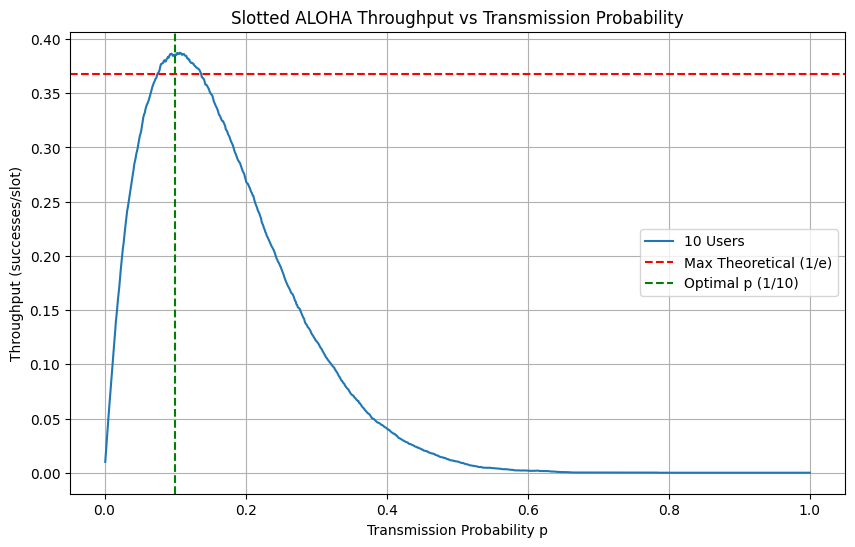

{'p': [0.001,
  0.002,
  0.003,
  0.004,
  0.005,
  0.006,
  0.007,
  0.008,
  0.009,
  0.01,
  0.011,
  0.012,
  0.013,
  0.014,
  0.015,
  0.016,
  0.017,
  0.018,
  0.019,
  0.02,
  0.021,
  0.022,
  0.023,
  0.024,
  0.025,
  0.026,
  0.027,
  0.028,
  0.029,
  0.03,
  0.031,
  0.032,
  0.033,
  0.034,
  0.035,
  0.036,
  0.037,
  0.038,
  0.039,
  0.04,
  0.041,
  0.042,
  0.043,
  0.044,
  0.045,
  0.046,
  0.047,
  0.048,
  0.049,
  0.05,
  0.051,
  0.052,
  0.053,
  0.054,
  0.055,
  0.056,
  0.057,
  0.058,
  0.059,
  0.06,
  0.061,
  0.062,
  0.063,
  0.064,
  0.065,
  0.066,
  0.067,
  0.068,
  0.069,
  0.07,
  0.071,
  0.072,
  0.073,
  0.074,
  0.075,
  0.076,
  0.077,
  0.078,
  0.079,
  0.08,
  0.081,
  0.082,
  0.083,
  0.084,
  0.085,
  0.086,
  0.087,
  0.088,
  0.089,
  0.09,
  0.091,
  0.092,
  0.093,
  0.094,
  0.095,
  0.096,
  0.097,
  0.098,
  0.099,
  0.1,
  0.101,
  0.102,
  0.103,
  0.104,
  0.105,
  0.106,
  0.107,
  0.108,
  0.109,
  0.11,
  0.111,
  0.112,

In [18]:
def plot_aloha_throughput(p_values, throughput_values, num_users=10):
  """
  Helper function to visualize ALOHA throughput results.
  Plots the observed throughput against theoretical limits.

  Parameters:
    p_values (list/array): List of transmission probabilities tested.
    throughput_values (list/array): Corresponding throughput results.
    num_users (int): Number of users (for marking optimal p).

  Returns:
    None: Displays the throughput curve.
  """
  import matplotlib.pyplot as plt
  import numpy as np

  plt.figure(figsize=(10, 6))
  plt.plot(p_values, throughput_values, label=f"{num_users} Users")

  # Max Theoretical (1/e)
  plt.axhline(y=1/np.e, color='r', linestyle='--', label="Max Theoretical (1/e)")

  # Optimal p (1/N)
  if num_users > 0:
      plt.axvline(x=1/num_users, color='g', linestyle='--', label=f"Optimal p (1/{num_users})")

  plt.title("Slotted ALOHA Throughput vs Transmission Probability")
  plt.xlabel("Transmission Probability p")
  plt.ylabel("Throughput (successes/slot)")
  plt.grid(True)
  plt.legend()
  plt.show()

def sweep_p_and_plot(num_users=10, num_slots=10000, num_points=1000):
  """
  Perform a parameter sweep for Slotted ALOHA probability p and plot throughput.
  Generates the throughput vs. load curve to identify the optimal operating point.

  Parameters:
    num_users (int): Number of users sharing the channel.
    num_slots (int): Number of slots to simulate for each p value.
    num_points (int): Number of p values to test between 0 and 1.

  Returns:
    dict: A dictionary with keys 'p' and 'throughput' containing lists of values.
  """
  #num points
  p_values = [i/num_points for i in range(1,num_points + 1)]
  recorded_throughputs = []

  #sweep the p's
  fixedSeed = 1234
  for p in p_values:
    results = simulate_slotted_aloha(num_users,p,num_slots,fixedSeed)
    recorded_throughputs.append(results['throughput'])

  output = {
     'p':p_values,
     'throughput': recorded_throughputs,
  }

  #plot?
  plot_aloha_throughput(p_values,recorded_throughputs,num_users)
  return output

#test
sweep_p_and_plot()


### Expected Output:
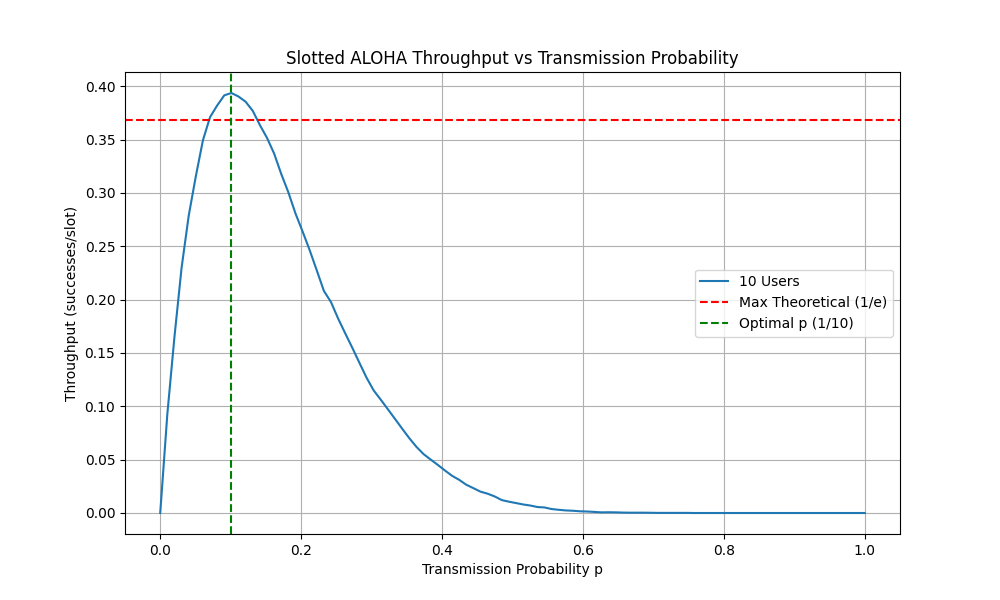


## CRC (Cyclic Redundancy Check)

CRC codes are widely used for error detection in Ethernet, Wi‑Fi, and many other network protocols.
In this part you will implement simple CRC generation and checking on bitstrings.


### 3.3 CRC Remainder (5 Marks)

In this problem you will implement a function that computes the CRC remainder for a given data bitstring and generator polynomial.

**Graded function - remainder**

- Name: `compute_crc_remainder`
- Signature: `compute_crc_remainder(data_bits, generator_bits)`
- Inputs:
 - `data_bits`: string of `'0'` and `'1'`.
 - `generator_bits`: string of `'0'` and `'1'` representing the generator polynomial.
- Return value:
 - A string of `'0'` and `'1'` representing the remainder.
 - Length must be `len(generator_bits) - 1`.
 - **Important:** The returned remainder string must be **padded with leading zeros** if necessary, so that its length is exactly `len(generator_bits) - 1`.


Example output shape (for illustration only):

```python
remainder = "010" # a short string of '0' and '1'
```


In [19]:
def compute_crc_remainder(data_bits, generator_bits):
  """
  Compute the Cyclic Redundancy Check (CRC) remainder for a data message.
  Uses modulo-2 division (XOR) with the generator polynomial.

  Parameters:
    data_bits (str): The original data bitstring.
    generator_bits (str): The generator polynomial bitstring.

  Returns:
    str: The computed remainder bitstring (padded to correct length).
  """
  genLength = len(generator_bits)
  dataLength = len(data_bits)
  remainder_length = genLength - 1
  #find dividend
  dividend = [int(bit) for bit in data_bits] + [0] * remainder_length

  #work seg by seg
  currSegment = dividend[:genLength] #-> go up to dividend[k] but not including
  generator = [int(bit) for bit in generator_bits]

  #do the XOR division
  for i in range(dataLength):
    if currSegment[0] == 1:
      #subtraction without borrowing 0\0, 1\1 = 0, 1\0 OR 0\1 = 1
      for j in range(genLength):
        currSegment[j] = currSegment[j] ^ generator[j]
    if i < dataLength - 1:
      currSegment = currSegment[1:] + dividend[i + genLength]
    else:
      pass

  finalRemBits = currSegment[1:]
  remString = "".join(str(bit) for bit in finalRemBits)

  if len(remString) < remainder_length:
    remString = remString.zfill(remainder_length) #zfill fills with padding
  return remString




### 3.4 - CRC Encoding (5 Marks)

Now implement a function that appends CRC bits to `data_bits` to form a transmitted codeword.

**Graded function - encode**

- Name: `encode_crc`
- Signature: `encode_crc(data_bits, generator_bits)`
- Inputs:
 - `data_bits`: string of `'0'` and `'1'`.
 - `generator_bits`: string of `'0'` and `'1'`.
- Behavior:
 - You may call `compute_crc_remainder` inside `encode_crc`.
 - The result must start with `data_bits`.
 - The length of the result must be `len(data_bits) + len(generator_bits) - 1`.
- Return value: the full codeword bitstring.

Example output shape (for illustration only):

```python
codeword = "110101101" # data bits followed by CRC bits
```
**Note:** Append `len(generator_bits) - 1` zeros to the end of `data_bits` before computing the CRC remainder. This padding is required; without it, the remainder is mathematically incorrect for CRC purposes.


In [20]:
def encode_crc(data_bits, generator_bits):
  """
  Generate a CRC-protected codeword by appending the remainder to the data.
  Creates a message that can be checked for transmission errors.

  Parameters:
    data_bits (str): The original data bitstring.
    generator_bits (str): The generator polynomial bitstring.

  Returns:
    str: The full codeword (data + remainder).
  """
  reminader = compute_crc_remainder(data_bits,generator_bits)

  codeword = data_bits + reminader
  return codeword

### 3.5 - CRC Error Detection (5 Marks)

In this problem you will implement a function that checks whether a received codeword has a zero CRC remainder.

**Graded function - check**

- Name: `check_crc`
- Signature: `check_crc(codeword_bits, generator_bits)`
- Inputs:
 - `codeword_bits`: string of `'0'` and `'1'` containing data bits plus CRC bits.
 - `generator_bits`: string of `'0'` and `'1'` for the generator polynomial.
- Return value: `True` if the CRC remainder is all zeros (no error detected), otherwise `False`.

Given a codeword created by `encode_crc(data_bits, generator_bits)`, `check_crc` should return `True` for the uncorrupted codeword and `False` if errors are detected. **Note:** CRC codes cannot detect every possible multi-bit error pattern (e.g., some specific combinations of bit flips), but they reliably detect the most common error patterns, including all single-bit errors and most burst errors.

Example output shape (for illustration only):

```python
ok = check_crc("100001110101000", "1010") # ok is a boolean, e.g. True
```


In [21]:
def check_crc(codeword_bits, generator_bits):
  """
  Verify whether a received CRC codeword contains errors.
  Checks if the remainder of the codeword division is zero.

  Parameters:
    codeword_bits (str): The received bitstring (potentially with errors).
    generator_bits (str): The generator polynomial bitstring.

  Returns:
    bool: True if no errors detected (remainder is zero), False otherwise.
  """
  genLength = len(generator_bits)
  codeWordLength = len(codeword_bits)
  remainderLength = genLength - 1

  currSegment = [int(bit) for bit in codeword_bits[:genLength]]
  generator = [int(bit) for bit in generator_bits]

  numIterations = codeWordLength - genLength + 1
  for i in range(numIterations):
    if currSegment[0] == 1:
      for j in range(genLength):
        currSegment[j] = currSegment[j] ^ generator[j]
    nextBitIndex = i + genLength
    if nextBitIndex < codeWordLength:
      currSegment = currSegment[1:] + [int(codeword_bits[nextBitIndex])]
    else:
      pass

  finalRemBits = currSegment[1:]

  #check if remainder is 0
  if sum(finalRemBits) == 0:
    CRCpass = True
  else: CRCpass = False

  return CRCpass

### 3.6 - Testing check_crc (5 Marks)

Use the following test cases to check your `check_crc` implementation.
These cells are graded; do not change the test expectations.


In [22]:

# testing case1, expected output: False (error detected)
ok = check_crc("10111010111010", "1110")
print(ok)

# testing case2, expected output: True (no error detected)
ok = check_crc("100001110101000", "1010")
print(ok)

# testing case3, expected output: False (error detected)
ok = check_crc("1001001110101101", "1111")
print(ok)


False
True
False
